In [1]:
import math
import numpy as np
import matplotlib.pylab as plt
np.set_printoptions(precision=2)
import scipy.io as sio
from math import erf
from typing import Tuple
import random
import os
import matplotlib.ticker as ticker
from tqdm.notebook import tqdm_notebook
from sklearn.metrics import mean_squared_error

# Import z ModelsCollection (soubor, kde budu ukládat všechny modely pro snazší použití)
import sys
sys.path.append('..')
from ModelsCollection import *

In [2]:
# skrytwarningsningů (kvůli LASSO, které vrací warnings kvůli konvergenci)
import warnings
warnings.filterwarnings('ignore')

In [3]:
def generate_xk(p, seed, times=4):
    """
    Generates data from single point on map
    """
    rng = np.random.default_rng(seed=seed)
    # X random čísla z <0,10)
    output = [10 * rng.random(size=p) for i in range(0,times)]

    # transpozice, aby sloupce odpovídaly časům
    return np.matrix(output).T.A

def generate_X(p, damageData = False, dropColumn = False, seed=40693057, spaces=9, times=4):
    """
    Returns data X (damage = divides columns by 10)
    
    data X has shape (p,spaces*times)
    """
    if damageData == True:
        # Měření z prvního políčka (0,1,2,3) - nevýznamné měření
        # A zároveň měření v časech t2 a t3 na políčku šest (22,23) - významné měření
        damageData = [0,1,2,3,22,23]
    if damageData == False:
        # Vypnutí poškození sloupců
        damageData = []
        
    random.seed(seed)
    seeds = [random.randint(0,10000) for i in range(0,spaces)]
    
    tmp = [generate_xk(p, seeds[i],times=times) for i in range(0,len(seeds))]

    finalX = np.zeros((p,spaces*times))
    for i in range(0,spaces):
        finalX[:, 0+times*i:times+times*i] = tmp[i]
    
    # Poškození dat
    for col in damageData:
        finalX[:,col] = finalX[:,col] / 10
    
    if dropColumn:
        # Výpadek významného sloupce s indexem 9
        finalX[:,9] = 0
    
    return finalX


def generate_y(X, sMatrixTrue, seed=40693057, sigma=1):
    rng = np.random.default_rng(seed=seed)
    
    output_y = np.multiply(X, sMatrix.flatten()).sum(axis=1)
    if sigma != 0:
        output_y = (output_y + rng.normal(loc=0, scale=sigma, size=1)).A
    # pro jistotu: nahrazení hodnot menších než 0, 0
    output_y[output_y < 0] = 0

    return output_y

def generateData(p, sMatrix, sigma, damageData, dropColumn, seed=40693057, spaces=9, times=4):
    X = generate_X(p, damageData = damaged, dropColumn = dropColumn,seed=seed, spaces = spaces, times = times)
    y = generate_y(X, sMatrix, sigma = sigma, seed = seed)
    beta_true = sMatrix.flatten().T
    return np.array(X),np.array(y),np.array(beta_true)

def getValuesPrintless(maxData, sMatrix, sigma, damageData, dropColumn, iterCount, function, seed=40693057,**kwargs):
    rangeToPlot = range(5,maxData+1) # minimálně 5 datových bodů
    x = [i for i in rangeToPlot]
    betaRMSE = []
    for i in rangeToPlot: #5,...,50
        X,y,beta_true = generateData(i,sMatrix,sigma=sigma,damageData=damaged,dropColumn=dropColumn, seed=seed)
        betaHat,_,_ = function(X,y,iterCount=iterCount,**kwargs)
        betaRMSE.append(np.sqrt(mean_squared_error(beta_true.reshape(-1),betaHat.reshape(-1))))
    return x,betaRMSE


Simulace

In [4]:
def RunSimulationVB(noiseSigma, damaged,dropCol, maxData, seed, repeat):
    random.seed(seed)
    if repeat > 0:
        seeds = [random.randint(65165,841610651) for i in range(0,repeat)]
    
    l0=-1
    xTime, betaRMSETimeOnly = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount,bayesLVLGeneralPositiveRegression,seed=seed, l0=l0, activeL=activeLTimeOnly)
    xSpace, betaRMSESpaceOnly = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount,bayesLVLGeneralPositiveRegression,seed=seed, l0=l0, activeL=activeLSpaceOnly)
    xSpaceAndTime, betaRMSESpaceAndTime = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount,bayesLVLGeneralPositiveRegression,seed=seed, l0=l0, activeL=activeLSpaceAndTime)
    xSparse, betaRMSESparse = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount, positiveSparseBayesRegression,seed=seed)
    xSmooth, betaRMSESmooth = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount, bayesLVLPositiveRegression,seed=seed, l0=l0)
    # převod pro lepší manipulaci
    betaRMSESparse = np.array(betaRMSESparse)
    betaRMSESpaceAndTime = np.array(betaRMSESpaceAndTime)
    betaRMSESpaceOnly = np.array(betaRMSESpaceOnly)
    betaRMSETimeOnly = np.array(betaRMSETimeOnly)
    betaRMSESmooth = np.array(betaRMSESmooth)
    
    if repeat > 0:
        for repeatNum,seedRepeat in enumerate(seeds):
            xTime, betaRMSETimeOnlyTMP = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount,bayesLVLGeneralPositiveRegression,seed=seedRepeat, l0=l0, activeL=activeLTimeOnly)
            xSpace, betaRMSESpaceOnlyTMP = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount,bayesLVLGeneralPositiveRegression,seed=seedRepeat, l0=l0, activeL=activeLSpaceOnly)
            xSpaceAndTime, betaRMSESpaceAndTimeTMP = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount,bayesLVLGeneralPositiveRegression,seed=seedRepeat, l0=l0, activeL=activeLSpaceAndTime)
            xSparse, betaRMSESparseTMP = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount, positiveSparseBayesRegression,seed=seedRepeat)
            xSmooth, betaRMSESmoothTMP = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount, bayesLVLPositiveRegression,seed=seedRepeat, l0=l0)
            betaRMSETimeOnly = np.array(betaRMSETimeOnly) + np.array(betaRMSETimeOnlyTMP)
            betaRMSESpaceOnly = np.array(betaRMSESpaceOnly) + np.array(betaRMSESpaceOnlyTMP)
            betaRMSESpaceAndTime = np.array(betaRMSESpaceAndTime) + np.array(betaRMSESpaceAndTimeTMP)
            betaRMSESparse = np.array(betaRMSESparse) + np.array(betaRMSESparseTMP)
            betaRMSESmooth = np.array(betaRMSESmooth) + np.array(betaRMSESmoothTMP)

    # vyplotění v matplotlibu
    if repeat < 0:
        repeat = 0
    repeat = repeat + 1

    toPlotArr = [
        (xSparse, betaRMSESparse/repeat, "Řídký model", "orange"),
        (xSmooth, betaRMSESmooth/repeat, "Hladký i řídký model", "cyan"),
        (xTime, betaRMSETimeOnly/repeat, "Časový model","red"),
        (xSpace, betaRMSESpaceOnly/repeat, "Prostorový model","green"),
        (xSpaceAndTime, betaRMSESpaceAndTime/repeat, "Časoprostorový model", "blue"),
    ]
    return toPlotArr

def PlotSimulation(ax, toPlotArr, ylimSet, logScale=True):
    plotsInfo = []
    labelsPure = []
    for item in toPlotArr:
        # tmp, = ax.plot(item[0], item[1], label=item[2], color=item[3], linewidth=2.0, marker="o", linestyle='dashed')
        tmp, = ax.plot(item[0], item[1], label=item[2], color=item[3], linewidth=2.0, marker="o", linestyle='')
        plotsInfo.append(tmp)
        labelsPure.append(item[2])
    ax.set_xlabel("Počet datových bodů pro každé pole")
    ax.set_ylabel("RMSE")
    # ax.legend()
    if logScale:
        ax.set_yscale("log")
        ax.set_ylabel("RMSE (log měřítko)")
    else:
        ax.set_ylim(0,ylimSet)
    return plotsInfo,labelsPure

In [5]:
def RunSimulationApriori(noiseSigma, damaged, dropCol, maxData, seed, repeat):
    random.seed(seed)
    if repeat > 0:
        seeds = [random.randint(65165,841610651) for i in range(0,repeat)]
    
    l0=-1
    activeLSmooth = [[i+1] for i in range(0,sMatrix.shape[0]*sMatrix.shape[1]-1)] 
    betaIn = sMatrix.flatten().T.reshape(-1,1)
    xTime, betaRMSETimeOnly = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount,bayesGeneralLVLRegressionWithBetaPositive,seed=seed, l0=l0, activeL=activeLTimeOnly, betaIn = betaIn)
    xSpace, betaRMSESpaceOnly = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount,bayesGeneralLVLRegressionWithBetaPositive,seed=seed, l0=l0, activeL=activeLSpaceOnly, betaIn = betaIn)
    xSpaceAndTime, betaRMSESpaceAndTime = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount,bayesGeneralLVLRegressionWithBetaPositive,seed=seed, l0=l0, activeL=activeLSpaceAndTime, betaIn = betaIn)
    xSmooth, betaRMSESmooth = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount, bayesGeneralLVLRegressionWithBetaPositive,seed=seed, l0=l0, activeL=activeLSmooth, betaIn = betaIn)
    # převod pro lepší manipulaci
    betaRMSESpaceAndTime = np.array(betaRMSESpaceAndTime)
    betaRMSESpaceOnly = np.array(betaRMSESpaceOnly)
    betaRMSETimeOnly = np.array(betaRMSETimeOnly)
    betaRMSESmooth = np.array(betaRMSESmooth)
    
    if repeat > 0:
        for repeatNum,seedRepeat in enumerate(seeds):
            xTime, betaRMSETimeOnlyTMP = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount,bayesGeneralLVLRegressionWithBetaPositive,seed=seedRepeat, l0=l0, activeL=activeLTimeOnly, betaIn = betaIn)
            xSpace, betaRMSESpaceOnlyTMP = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount,bayesGeneralLVLRegressionWithBetaPositive,seed=seedRepeat, l0=l0, activeL=activeLSpaceOnly, betaIn = betaIn)
            xSpaceAndTime, betaRMSESpaceAndTimeTMP = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount,bayesGeneralLVLRegressionWithBetaPositive,seed=seedRepeat, l0=l0, activeL=activeLSpaceAndTime, betaIn = betaIn)
            xSmooth, betaRMSESmoothTMP = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount, bayesGeneralLVLRegressionWithBetaPositive,seed=seedRepeat, l0=l0, activeL=activeLSmooth, betaIn = betaIn)
            betaRMSETimeOnly = np.array(betaRMSETimeOnly) + np.array(betaRMSETimeOnlyTMP)
            betaRMSESpaceOnly = np.array(betaRMSESpaceOnly) + np.array(betaRMSESpaceOnlyTMP)
            betaRMSESpaceAndTime = np.array(betaRMSESpaceAndTime) + np.array(betaRMSESpaceAndTimeTMP)
            betaRMSESmooth = np.array(betaRMSESmooth) + np.array(betaRMSESmoothTMP)

    # vyplotění v matplotlibu
    if repeat < 0:
        repeat = 0
    repeat = repeat + 1

    # ax.set_title(f"Modely s apriorní informací")
    # ax.set_xlabel("Počet datových bodů pro každé pole")
    # ax.set_ylabel("RMSE")
    

    toPlotArr = [
        (xSmooth, betaRMSESmooth/repeat, "Hladký i řídký model (apriorní beta)","darkcyan"),
        (xTime, betaRMSETimeOnly/repeat, "Časový model (apriorní beta)","darkred"),
        (xSpace, betaRMSESpaceOnly/repeat, "Prostorový model (apriorní beta)","darkgreen"),
        (xSpaceAndTime, betaRMSESpaceAndTime/repeat, "Časoprostorový model (apriorní beta)","darkblue"),
    ]
    return toPlotArr

In [6]:
def RunSimulationClassical(noiseSigma, damaged, dropCol, maxData, seed, repeat):
    random.seed(seed)
    if repeat > 0:
        seeds = [random.randint(65165,841610651) for i in range(0,repeat)]
    
    xLinearR, betaRMSELinearR = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount,LinearRegressionGetBeta,seed=seed)
    xRidgeR, betaRMSERidgeR = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount,RidgeGetBeta,seed=seed,alphasRange=alphasRange)
    xLASSO, betaRMSELASSO = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount,LASSOGetBeta,seed=seed,alphasRange=alphasRange)
    
    # převod pro lepší manipulaci
    betaRMSELinearR = np.array(betaRMSELinearR)
    betaRMSERidgeR = np.array(betaRMSERidgeR)
    betaRMSELASSO = np.array(betaRMSELASSO)
    
    if repeat > 0:
        for repeatNum,seedRepeat in enumerate(seeds):
            xLinearR, betaRMSELinearRTMP = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount,LinearRegressionGetBeta,seed=seed)
            xRidgeR, betaRMSERidgeRTMP = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount,RidgeGetBeta,seed=seed,alphasRange=alphasRange)
            xLASSO, betaRMSELASSOTMP = getValuesPrintless(maxData,sMatrix,noiseSigma,damaged,dropCol,iterCount,LASSOGetBeta,seed=seed,alphasRange=alphasRange)

            betaRMSELinearR = np.array(betaRMSELinearR) + np.array(betaRMSELinearRTMP)
            betaRMSERidgeR = np.array(betaRMSERidgeR) + np.array(betaRMSERidgeRTMP)
            betaRMSELASSO = np.array(betaRMSELASSO) + np.array(betaRMSELASSOTMP)

    # vyplotění v matplotlibu
    if repeat < 0:
        repeat = 0
    repeat = repeat + 1

    toPlotArr = [
        (xLinearR, betaRMSELinearR/repeat, "Lineární regrese", "palegreen"),
        (xRidgeR, betaRMSERidgeR/repeat, "Hřebenové regrese (lambda dle křížové validace)", "pink"),
        (xLASSO, betaRMSELASSO/repeat, "LASSO (lambda dle křížové validace)", "purple")
    ]
    return toPlotArr

In [7]:
def RunAllSimulations(noiseSigma, damaged, dropColumn, maxData = 40, seed = 40693057, repeat=0, ylimSet=10, plotTitle="Popis situace", fileTitle="SituationX"):
    plt.rc("font", size=16)
    plt.rc("axes", titlesize=16)
    plt.rc("axes", labelsize=16)
    fig, axes = plt.subplots(4,2,figsize=(15, 16))
    plt.suptitle(f"Vyhodnocení modelů dle RMSE - {plotTitle}", fontsize=20, y = 1) #, y=0.90)

    toPlotVB = RunSimulationVB(noiseSigma, damaged,dropColumn, maxData, seed, repeat)
    toPlotApriori = RunSimulationApriori(noiseSigma, damaged,dropColumn, maxData, seed, repeat)
    toPlotClassical = RunSimulationClassical(noiseSigma, damaged,dropColumn, maxData, seed, repeat)
    toPlotAll = []
    for item in toPlotVB:
        toPlotAll.append(item)
    for item in toPlotApriori:
        toPlotAll.append(item)
    for item in toPlotClassical:
        toPlotAll.append(item)

    gridSpec = axes[0,0].get_gridspec()
    for ax in axes[0:2,0]:
        ax.remove()
    for ax in axes[0:2,1]:
        ax.remove()
    axbig = fig.add_subplot(gridSpec[0:2,0:2])

    axbig.set_title(f"Všechny modely")
    plotsInfo,labelsPure = PlotSimulation(axbig,toPlotAll, ylimSet, logScale=False)
    # axbig.legend()

    axes[2,0].set_title(f"Bez apriorní informace beta")
    PlotSimulation(axes[2,0],toPlotVB, ylimSet)
    # axes[2,0].legend()

    axes[2,1].set_title(f"S apriorní informací beta")
    PlotSimulation(axes[2,1],toPlotApriori, ylimSet)
    # axes[2,1].legend()

    axes[3,0].set_title(f"Klasické modely")
    PlotSimulation(axes[3,0],toPlotClassical, ylimSet)
    # axes[3,0].legend()

    axes[3,1].axis('off')
    axes[3,1].legend(plotsInfo,labelsPure, loc='center')


    plt.tight_layout(h_pad = 1.3)
    # plt.ylim(0,ylimSet)
    plt.savefig(f"dataFinalBenchmarks/RMSE/{fileTitle}.png", bbox_inches="tight", pad_inches=0.25)
    plt.show()

In [8]:
def plotExperiment(X,y,beta_true, plotTitle="Popis situace", fileTitle="SituationX"):
    # (title, function, kwargs)
    l0 = -1
    activeLSmooth = [[i+1] for i in range(0,beta_true.shape[0]-1)]
    
    betaIn = beta_true.reshape(-1,1)
    
    methods = [
        ("Lineární regrese",LinearRegressionGetBeta,{"iterCount":iterCount}),
        ("Hřebenová regrese",RidgeGetBeta,{"iterCount":iterCount,"alphasRange":alphasRange}),
        ("LASSO",LASSOGetBeta,{"iterCount":iterCount,"alphasRange":alphasRange}),
        ("Řídký model",positiveSparseBayesRegression,{"iterCount":iterCount}),
        ("Hladký i řídký model",bayesLVLPositiveRegression,{"iterCount":iterCount,"l0":l0}),
        ("Časový model",bayesLVLGeneralPositiveRegression,{"iterCount":iterCount,"l0":l0,"activeL":activeLTimeOnly}),
        ("Prostorový model",bayesLVLGeneralPositiveRegression,{"iterCount":iterCount,"l0":l0,"activeL":activeLSpaceOnly}),
        ("Časoprostorový model",bayesLVLGeneralPositiveRegression,{"iterCount":iterCount,"l0":l0,"activeL":activeLSpaceAndTime}),        
        ("Hladký i řídký model (apriorní emise)",bayesGeneralLVLRegressionWithBetaPositive,{"iterCount":iterCount,"l0":l0,"activeL":activeLSmooth, "betaIn":betaIn}),
        ("Časový model (apriorní emise)",bayesGeneralLVLRegressionWithBetaPositive,{"iterCount":iterCount,"l0":l0,"activeL":activeLTimeOnly, "betaIn":betaIn}),
        ("Prostorový model (apriorní emise)",bayesGeneralLVLRegressionWithBetaPositive,{"iterCount":iterCount,"l0":l0,"activeL":activeLSpaceOnly, "betaIn":betaIn}),
        ("Časoprostorový model (apriorní emise)",bayesGeneralLVLRegressionWithBetaPositive,{"iterCount":iterCount,"l0":l0,"activeL":activeLSpaceAndTime, "betaIn":betaIn})
    ]
    
    graphsPerRow = 3
    fig, axs = plt.subplots(len(methods)//graphsPerRow+len(methods)%graphsPerRow, graphsPerRow, figsize=(14,18), sharey=True)

    xVals = [i+1 for i in range(len(beta_true))]
    fig.suptitle(f"Srovnání odhadu a skutečného Beta - {plotTitle}")
    for ind, method in enumerate(methods):
        betaHat,sigmaBeta,hist_omega = method[1](X,y,**method[2])
        print(f"{method[0]} - RMSE: {np.sqrt(mean_squared_error(beta_true.reshape(-1),betaHat.reshape(-1))):.3f}")
        axs[ind//graphsPerRow,ind%graphsPerRow].set_title(f"{method[0]}")
        axs[ind//graphsPerRow,ind%graphsPerRow].plot(xVals,beta_true,color='red',linestyle='dashed',label="Skutečná Beta")
        axs[ind//graphsPerRow,ind%graphsPerRow].plot(xVals,betaHat,color = 'blue',label="Odhad Beta")
        unc_1 = np.matrix(betaHat)
        unc_2 = np.matrix(betaHat)
        if sigmaBeta is not None:
            unc_1 = np.matrix(betaHat) + np.matrix(np.sqrt(np.diag(sigmaBeta))).T
            unc_2 = np.matrix(betaHat) - np.matrix(np.sqrt(np.diag(sigmaBeta))).T
            axs[ind//graphsPerRow,ind%graphsPerRow].plot(xVals,unc_1,color = 'grey',linestyle='dashed',label="Nejistota Beta (1 sd)")
            axs[ind//graphsPerRow,ind%graphsPerRow].plot(xVals,unc_2,color = 'grey',linestyle='dashed')
            axs[ind//graphsPerRow,ind%graphsPerRow].set_ylim([-2,15])
    fig.supxlabel("Beta_x")
    fig.supylabel("Hodnoty Beta_x")
    axs[ind//graphsPerRow,ind%graphsPerRow].legend()
    plt.tight_layout()
    plt.savefig(f"dataFinalBenchmarks/Experiments/{fileTitle}.png", bbox_inches="tight", pad_inches=0.25)
    plt.show()

# Definice modelů
Porovnávám zde následující modely:
- Modely odvozené metodou variační Bayes bez apriorní informace o emisi
    - Základní model = řídká bayesovská regrese
    - Hladký i řídký model
    - Časový model
    - Prostorový model
    - Časoprostorový model
- Modely odvozené metodou variační Bayes s apriorní informací o emisi
    - Základní model = řídká bayesovská regrese
    - Hladký i řídký model
    - Časový model
    - Prostorový model
    - Časoprostorový model
- Klasické modely
    - Lineární regrese
    - Hřebenové regrese
    - LASSO

Všechny modely odvozené metodou variační Bayes zde beru s podmínkou nezápornosti. `l0 = -1` byla zvolena experimentálně, toto nastavení odpovídá apriorně zapnuté kovarianční struktuře (hladkosti či časové/prostorové/časoprostorové závislosti). Maximální počet iterací je 101.

U klasických modelů s regularizací (hřebenové regrese a LASSO) je využita křížová validace *leave-one-out* pro získání $\lambda$.

In [9]:
# max počet iterace
iterCount = 101

# definice maticí indexL
activeLSpaceAndTime = [
    [1,5,13], # 1, t0
    [2,6,14], # 1, t1
    [3,7,15], # 1, t2
    [], # 1, t3
    [5,9,17], # 2, t0
    [6,10,18], # 2, t1
    [7,11,19], # 2, t2
    [], # 2, t3
    [9,21], # 3, t0
    [10,22], # 3, t1
    [11,23], # 3, t2
    [], # 3, t3
    [13,17,25], # 4, t0
    [14,18,26], # 4, t1
    [15,19,27], # 4, t2
    [], # 4, t3
    [17,21,29], # 5, t0
    [18,22,30], # 5, t1
    [19,23,31], # 5, t2
    [], # 5, t3
    [21,33], # 6, t0
    [22,34], # 6, t1
    [23,35], # 6, t2
    [], # 6, t3
    [25,29], # 7, t0
    [26,30], # 7, t1
    [27,31], # 7, t2
    [], # 7, t3
    [29,33], # 8, t0
    [30,34], # 8, t1
    [31,35], # 8, t2
    [], # 8, t3
    [33], # 9, t0
    [34], # 9, t1
    [35], # 9, t2
]

activeLSpaceOnly = [
    [4,12], # 1, t0 - 0
    [5,13], # 1, t1 - 1
    [6,14], # 1, t2 - 2
    [7,15], # 1, t3 - 3
    [8,16], # 2, t0 - 4
    [9,17], # 2, t1
    [10,18], # 2, t2
    [11,19], # 2, t3
    [20], # 3, t0
    [21], # 3, t1
    [22], # 3, t2
    [23], # 3, t3
    [16,24], # 4, t0
    [17,25], # 4, t1
    [18,26], # 4, t2
    [19,27], # 4, t3
    [20,28], # 5, t0
    [21,29], # 5, t1
    [22,30], # 5, t2
    [23,31], # 5, t3
    [32], # 6, t0
    [33], # 6, t1
    [34], # 6, t2
    [35], # 6, t3
    [28], # 7, t0
    [29], # 7, t1
    [30], # 7, t2
    [31], # 7, t3
    [32], # 8, t0
    [33], # 8, t1
    [34], # 8, t2
    [35], # 8, t3
    [], # 9, t0
    [], # 9, t1
    [], # 9, t2
]

activeLTimeOnly = [
    [1],
    [2],
    [3],
    [],
    [5],
    [6],
    [7],
    [],
    [9],
    [10],
    [11],
    [],
    [13],
    [14],
    [15],
    [],
    [17],
    [18],
    [19],
    [],
    [21],
    [22],
    [23],
    [],
    [25],
    [26],
    [27],
    [],
    [29],
    [30],
    [31],
    [],
    [33],
    [34],
    [35],
]

# zkoušené hodnoty regularizačního parametru lambda
alphasRange =  [*np.arange(0.0001,1,0.001)]+[*np.arange(1.01,5,0.01)]+[*np.arange(6,16,0.1)]+[*np.arange(17,100,5)]

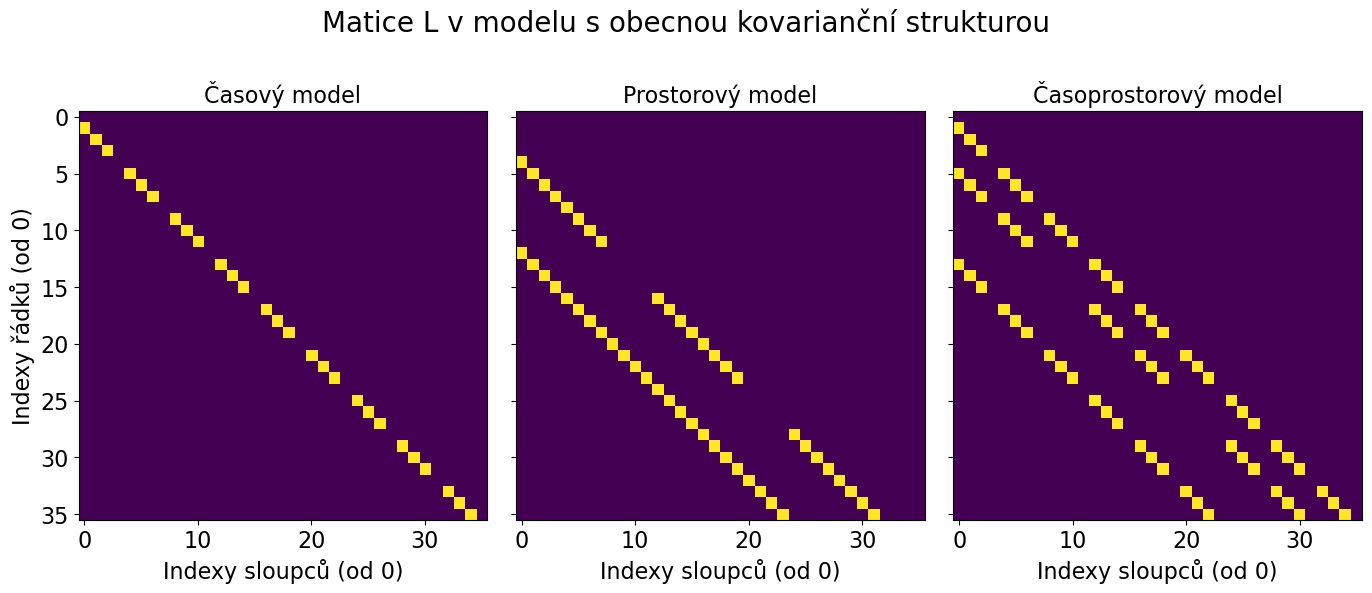

In [10]:
# Funkce pro převod
def MatLIndexToMatL(matLIndexIn):
    indexL = np.diag(np.zeros(len(matLIndexIn)+1))
    for col in range(0,len(matLIndexIn)):
        for row in matLIndexIn[col]:
            indexL[row,col] = 1
    return indexL

# vykreslení
def plotActiveL():
    plt.rc("font", size=16)
    plt.rc("axes", titlesize=16)
    plt.rc("axes", labelsize=16)
    fig,ax = plt.subplots(1,3,figsize=(14,14),sharey=True)
    plt.suptitle(f"Matice L v modelu s obecnou kovarianční strukturou", fontsize=20, y = 0.7)

    ax[0].imshow(MatLIndexToMatL(activeLTimeOnly))
    ax[1].imshow(MatLIndexToMatL(activeLSpaceOnly))
    ax[2].imshow(MatLIndexToMatL(activeLSpaceAndTime))

    ax[0].set_title("Časový model")
    ax[1].set_title("Prostorový model")
    ax[2].set_title("Časoprostorový model")
    
    ax[0].set_xlabel("Indexy sloupců (od 0)")
    ax[1].set_xlabel("Indexy sloupců (od 0)")
    ax[2].set_xlabel("Indexy sloupců (od 0)")
    ax[0].set_ylabel("Indexy řádků (od 0)")
    plt.tight_layout()
    plt.show()
    
plotActiveL()

# Testované situace

Testy jsou děleny dle situací (5) a poté dle nastavení samotné simulace (poškození dat/úrovně šumu/dodatečná manipulace s daty).

Situace jsou definovány maticí `sMatrix` (*situation matrix*), která představuje skutečnost pro $\beta$.

U každého testu je ukázán vývoj RMSE (*root mean square error*) pro každý z uvažovaných modelů a pro různý počet měření (toto je omezeno parametrem `maxData` na 40). Matice X je náhodně generována a vektor y je spočítán dle $X\beta$ plus šum dle úrovně šumu.

In [11]:
maxData = 40

## Situace 1 - základní řídký případ

Popis `sMatrix`:
- řádek představuje jedno políčko z mapy 3x3 (9 políček), číslováno z levého horního rohu (tedy po řádcích: 1,2,3; 4,5,6; 7,8,9)
- sloupec představuje čas měření


**Náčrt situace**:

|  |  |  |
|-----------|-----------|-----------|
| 0 | 0 | release1 |
| release4 | release3 | release2 |
| 0 | 0 | 0 |

Kde v rámci časů 1,2,3,4:
- release 1: 2,2,0,0
- release 2: 0,3,3,0
- release 3: 0,0,1,1
- release 4: 0,0,0,2

Interpretace volby: požár nastal na release1 a poté se rozšířil na jih (release2) odkud se šířil dál na západ (release3,release4). Intenzita se postupem požáru někdy zvýšila a někdy snížila.  

In [12]:
sMatrix = np.matrix(
    [
        [0,0,0,0],
        [0,0,0,0],
        [2,2,0,0],
        [0,0,0,2],
        [0,0,1,1],
        [0,3,3,0],
        [0,0,0,0],
        [0,0,0,0],
        [0,0,0,0]
    ])

### Test 1 - baseline

- Bez šumu 
- Bez poškození matice X
- Bez výpadku

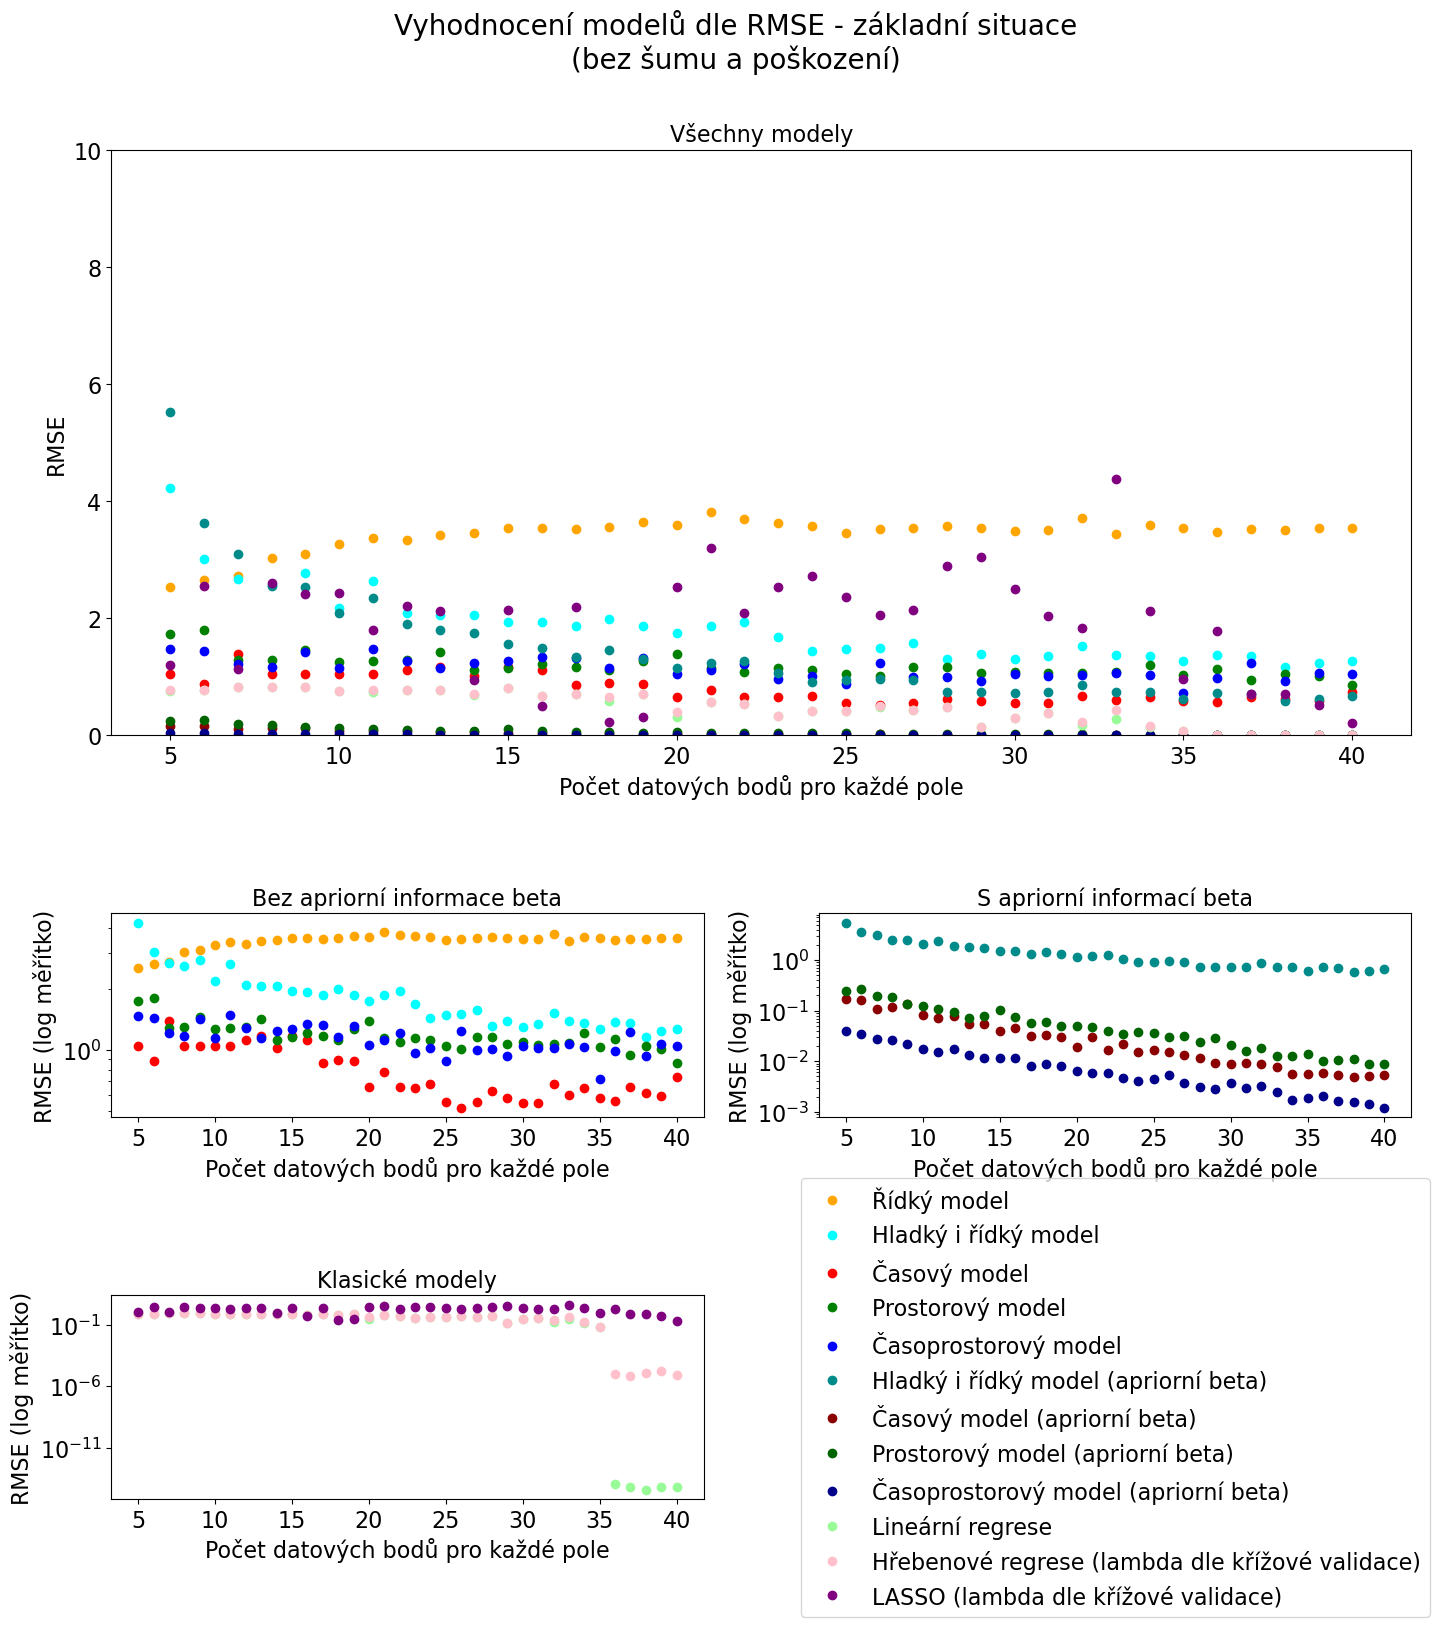

In [13]:
noiseSigma = 0
damaged = False
dropColumn = False
plotTitle = "základní situace\n(bez šumu a poškození)"
fileTitle = "Situation1Basic"
RunAllSimulations(noiseSigma, damaged, dropColumn, maxData = maxData, seed = 40693057, repeat=0, ylimSet=10, plotTitle=plotTitle, fileTitle=fileTitle)

Lineární regrese - RMSE: 0.682
Hřebenová regrese - RMSE: 0.702
LASSO - RMSE: 0.944
Řídký model - RMSE: 3.461
Hladký i řídký model - RMSE: 2.061
Časový model - RMSE: 1.017
Prostorový model - RMSE: 1.114
Časoprostorový model - RMSE: 1.242
Hladký i řídký model (apriorní emise) - RMSE: 1.743
Časový model (apriorní emise) - RMSE: 0.055
Prostorový model (apriorní emise) - RMSE: 0.078
Časoprostorový model (apriorní emise) - RMSE: 0.012


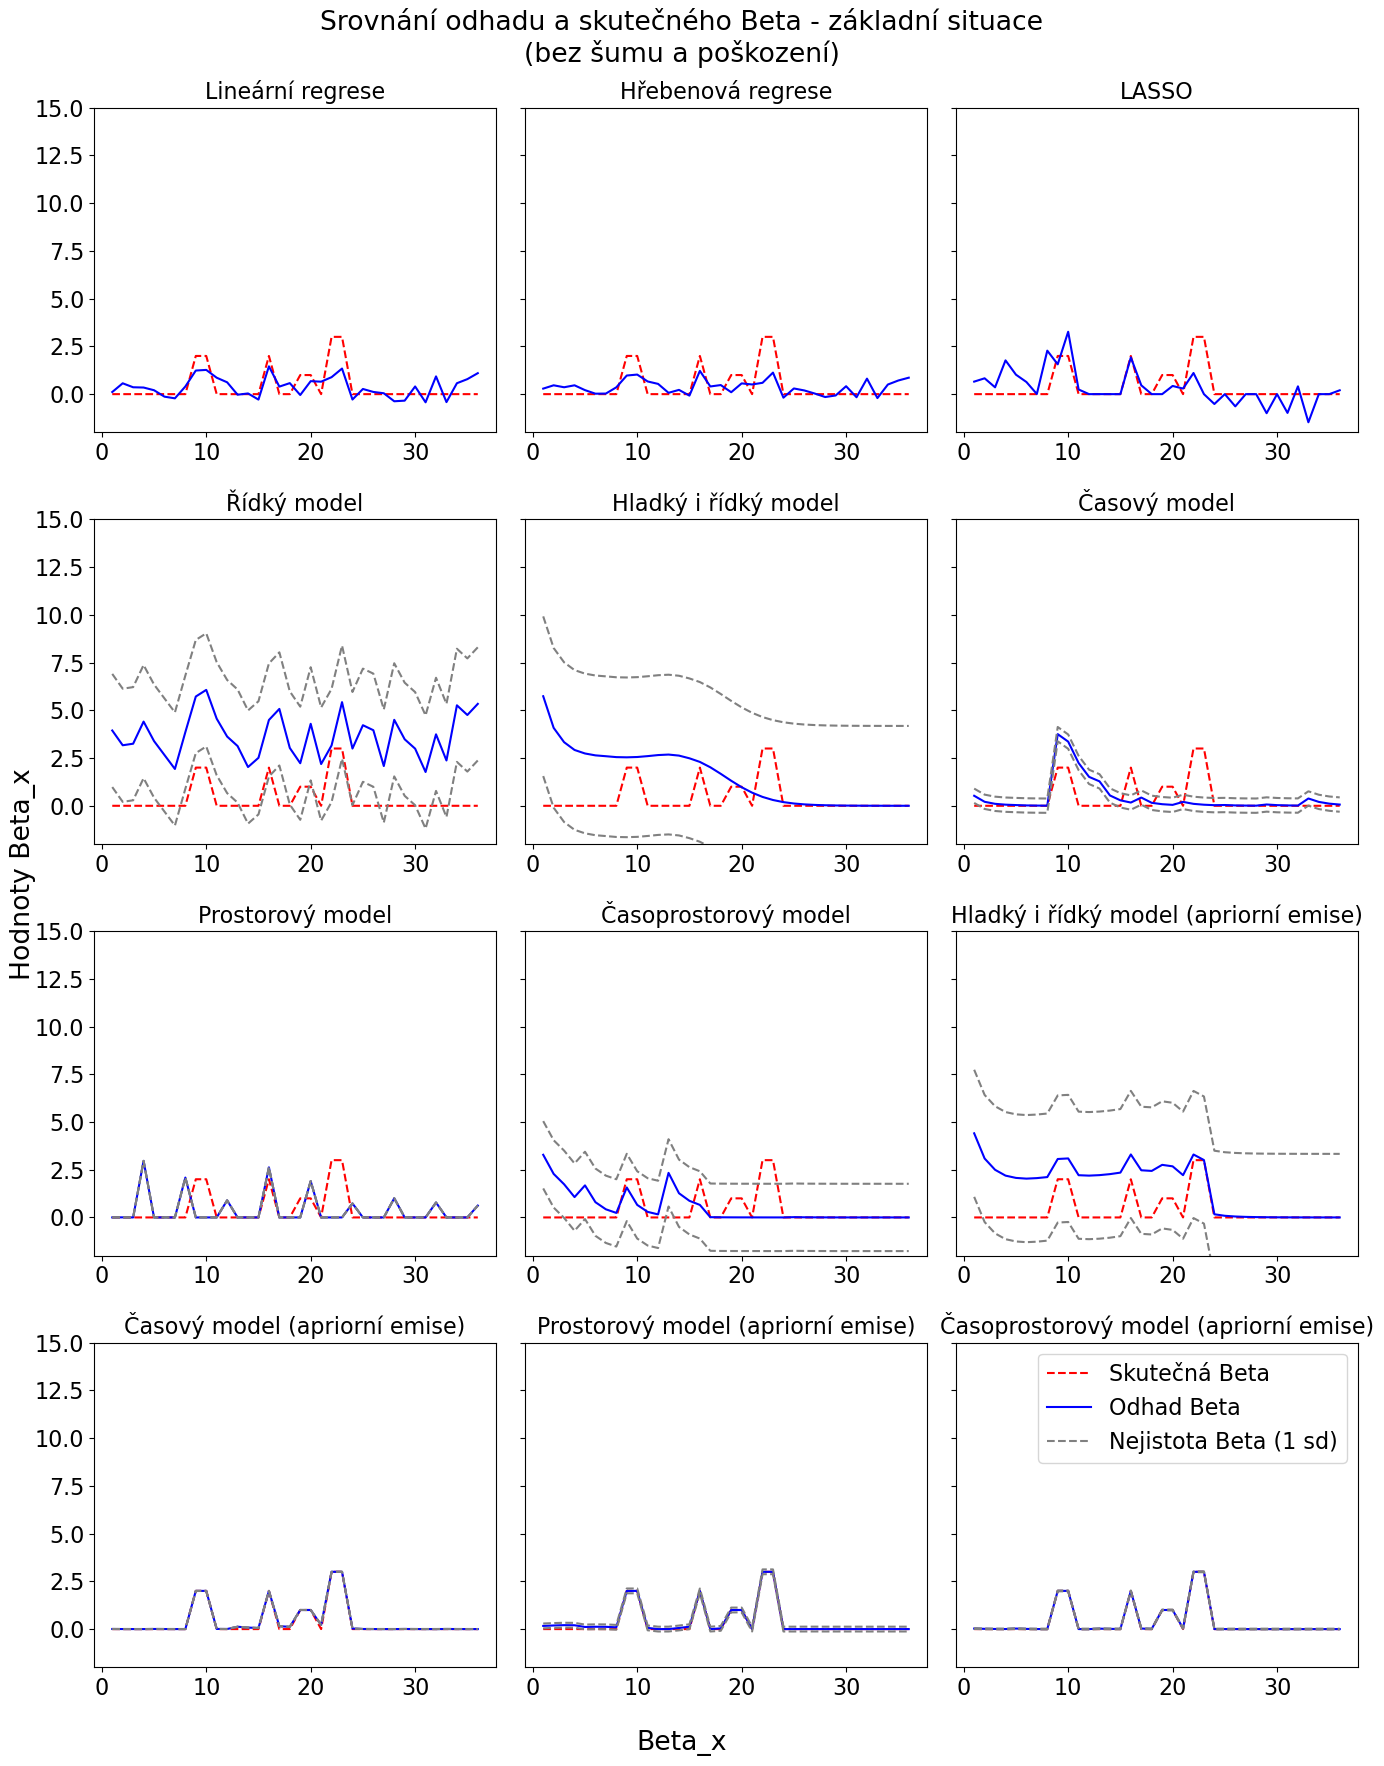

In [14]:
X,y,beta_true = generateData(14, sMatrix, sigma=noiseSigma, damageData=damaged, dropColumn=dropColumn)
plotExperiment(X, y, beta_true, plotTitle=plotTitle, fileTitle=fileTitle)

### Test 2 - šum

- Šum: $\sigma$ = 5 
- Bez poškození matice X
- Bez výpadku

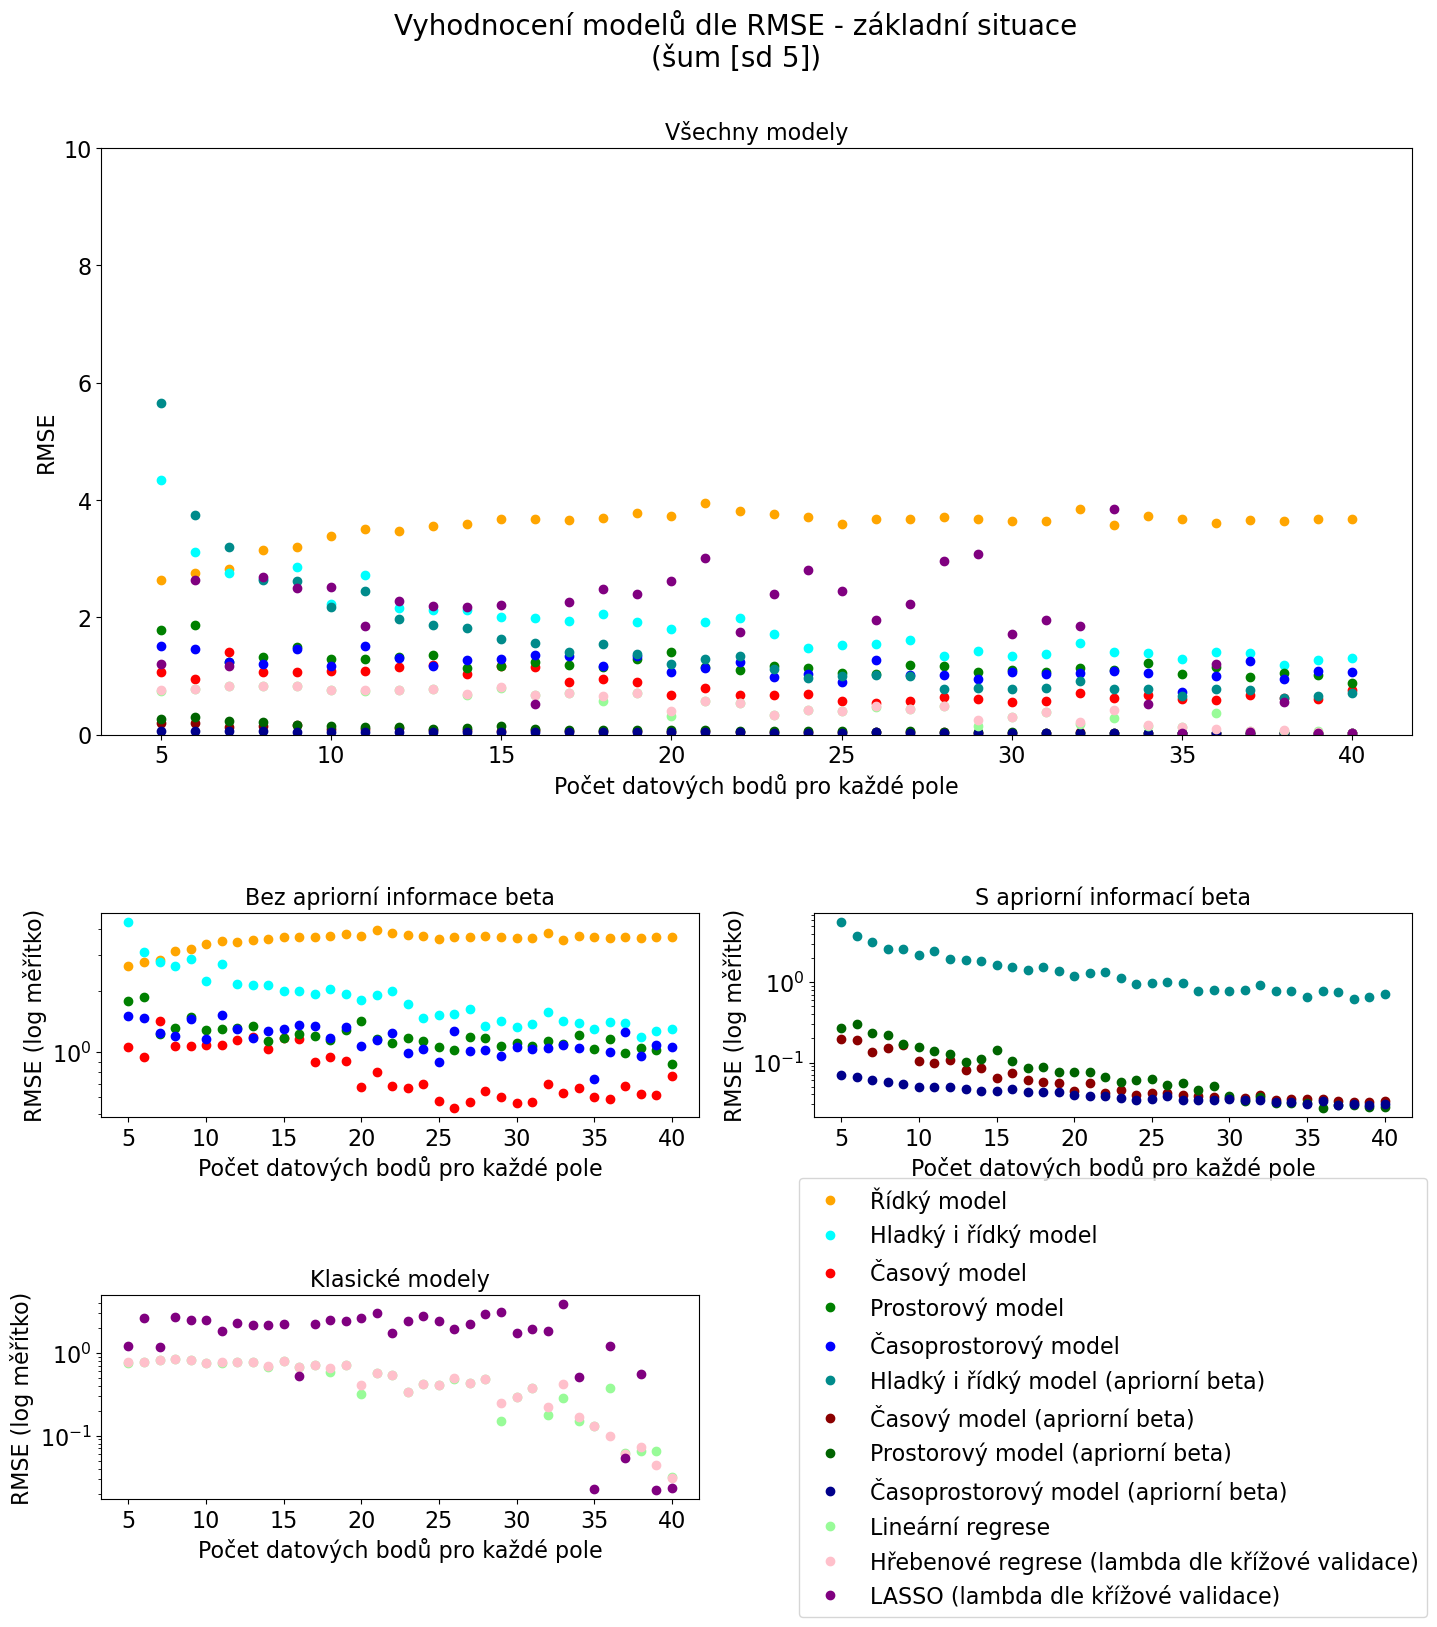

In [15]:
noiseSigma = 5
damaged = False
dropColumn = False
plotTitle = "základní situace\n(šum [sd 5])"
fileTitle = "Situation1Noisy"
RunAllSimulations(noiseSigma, damaged, dropColumn, maxData = maxData, seed = 40693057, repeat=0, ylimSet=10, plotTitle=plotTitle, fileTitle=fileTitle)

Lineární regrese - RMSE: 0.683
Hřebenová regrese - RMSE: 0.700
LASSO - RMSE: 2.183
Řídký model - RMSE: 3.599
Hladký i řídký model - RMSE: 2.124
Časový model - RMSE: 1.042
Prostorový model - RMSE: 1.134
Časoprostorový model - RMSE: 1.268
Hladký i řídký model (apriorní emise) - RMSE: 1.822
Časový model (apriorní emise) - RMSE: 0.085
Prostorový model (apriorní emise) - RMSE: 0.112
Časoprostorový model (apriorní emise) - RMSE: 0.044


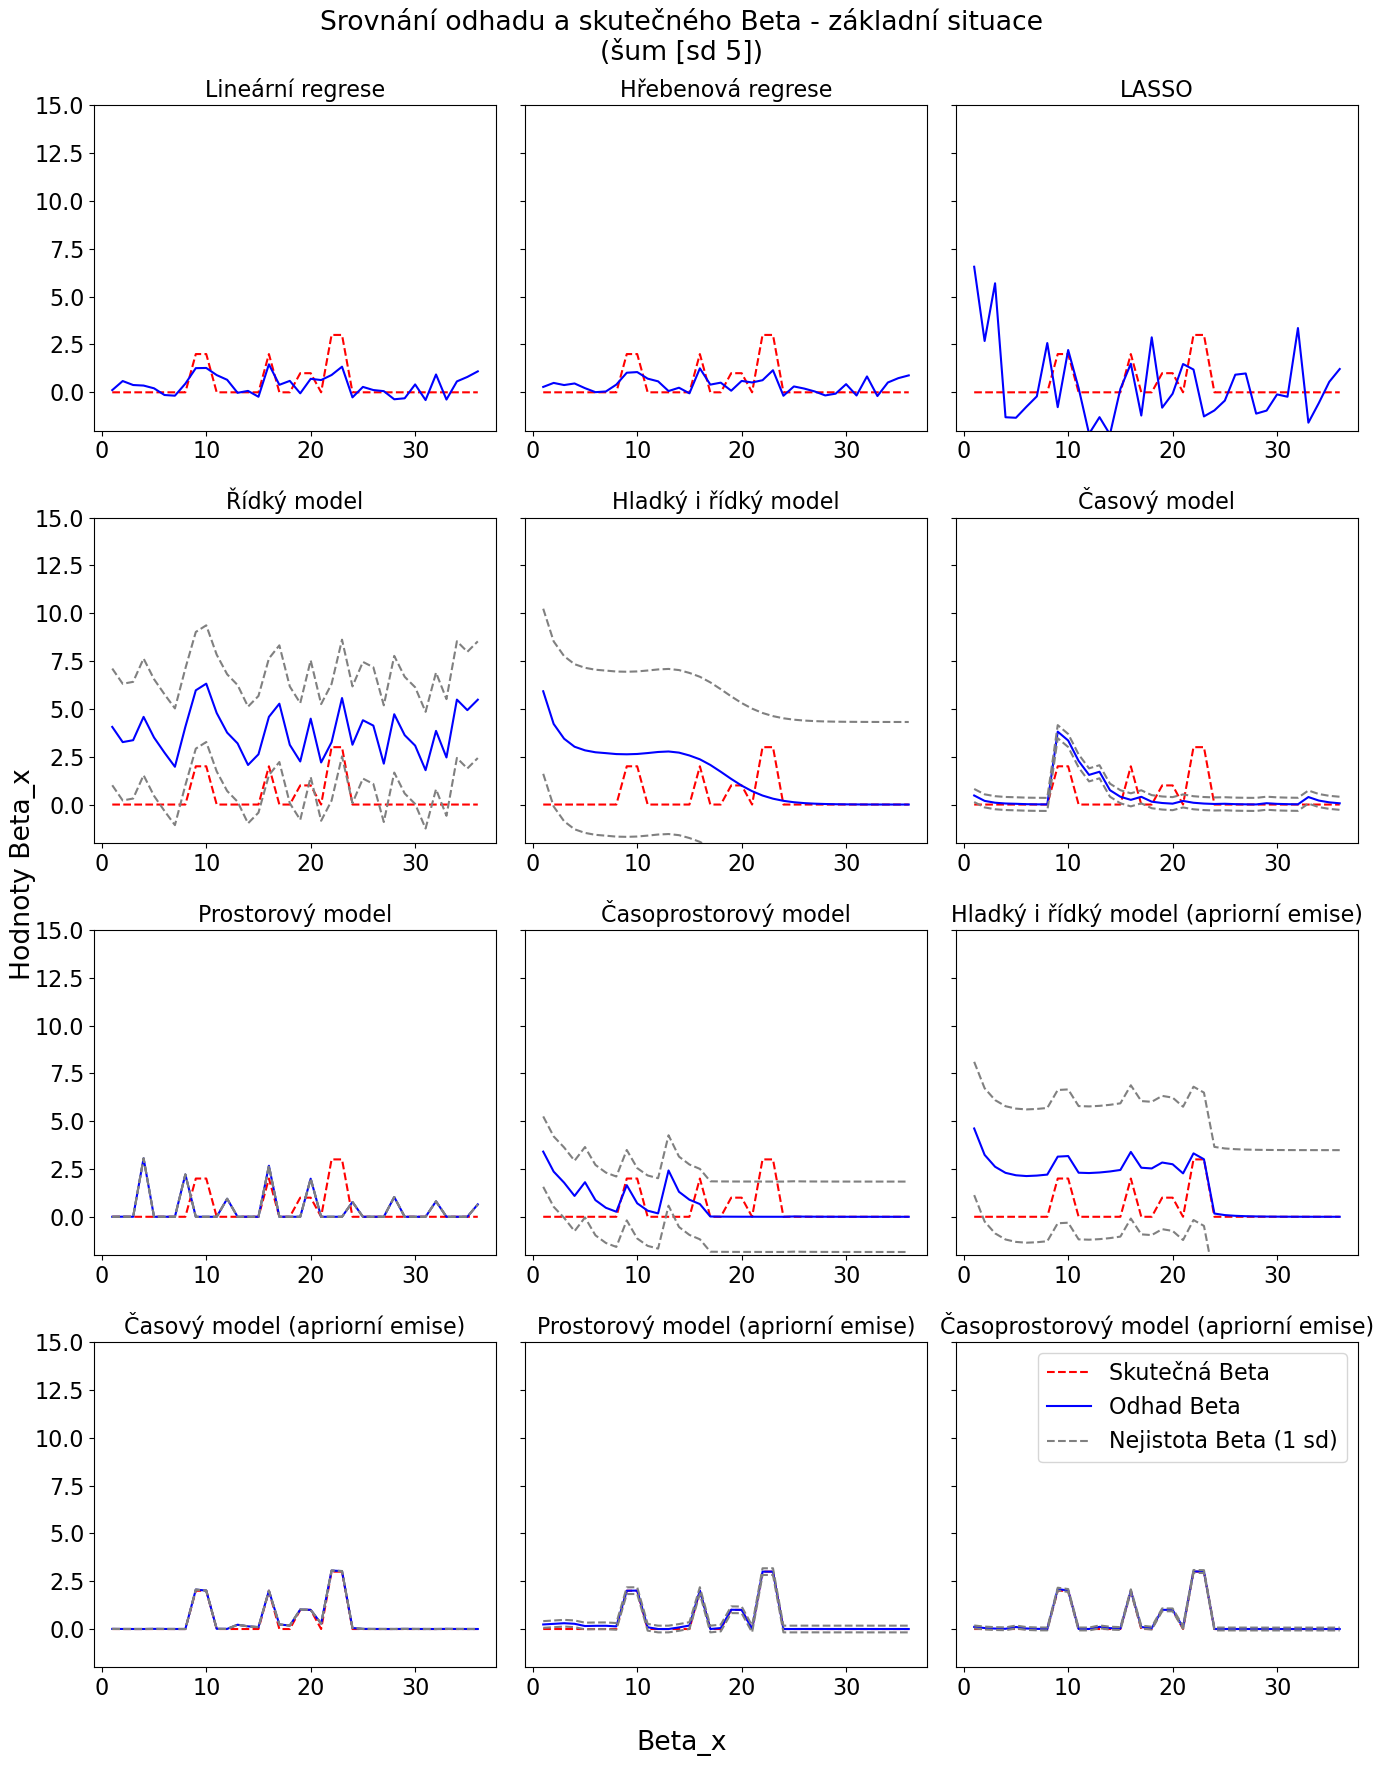

In [16]:
X,y,beta_true = generateData(14, sMatrix, sigma=noiseSigma, damageData=damaged, dropColumn=dropColumn)
plotExperiment(X, y, beta_true, plotTitle=plotTitle, fileTitle=fileTitle)

### Test 3 - poškození významnosti matice X

- Bez šumu
- V matici X byly přeškálovany (vyděleny 10) sloupce odpovídající:
    - prvnímu políčku (všechny časy);
    - časy `t2`, `t3` na pátém políčku.  
- Bez výpadku sloupce

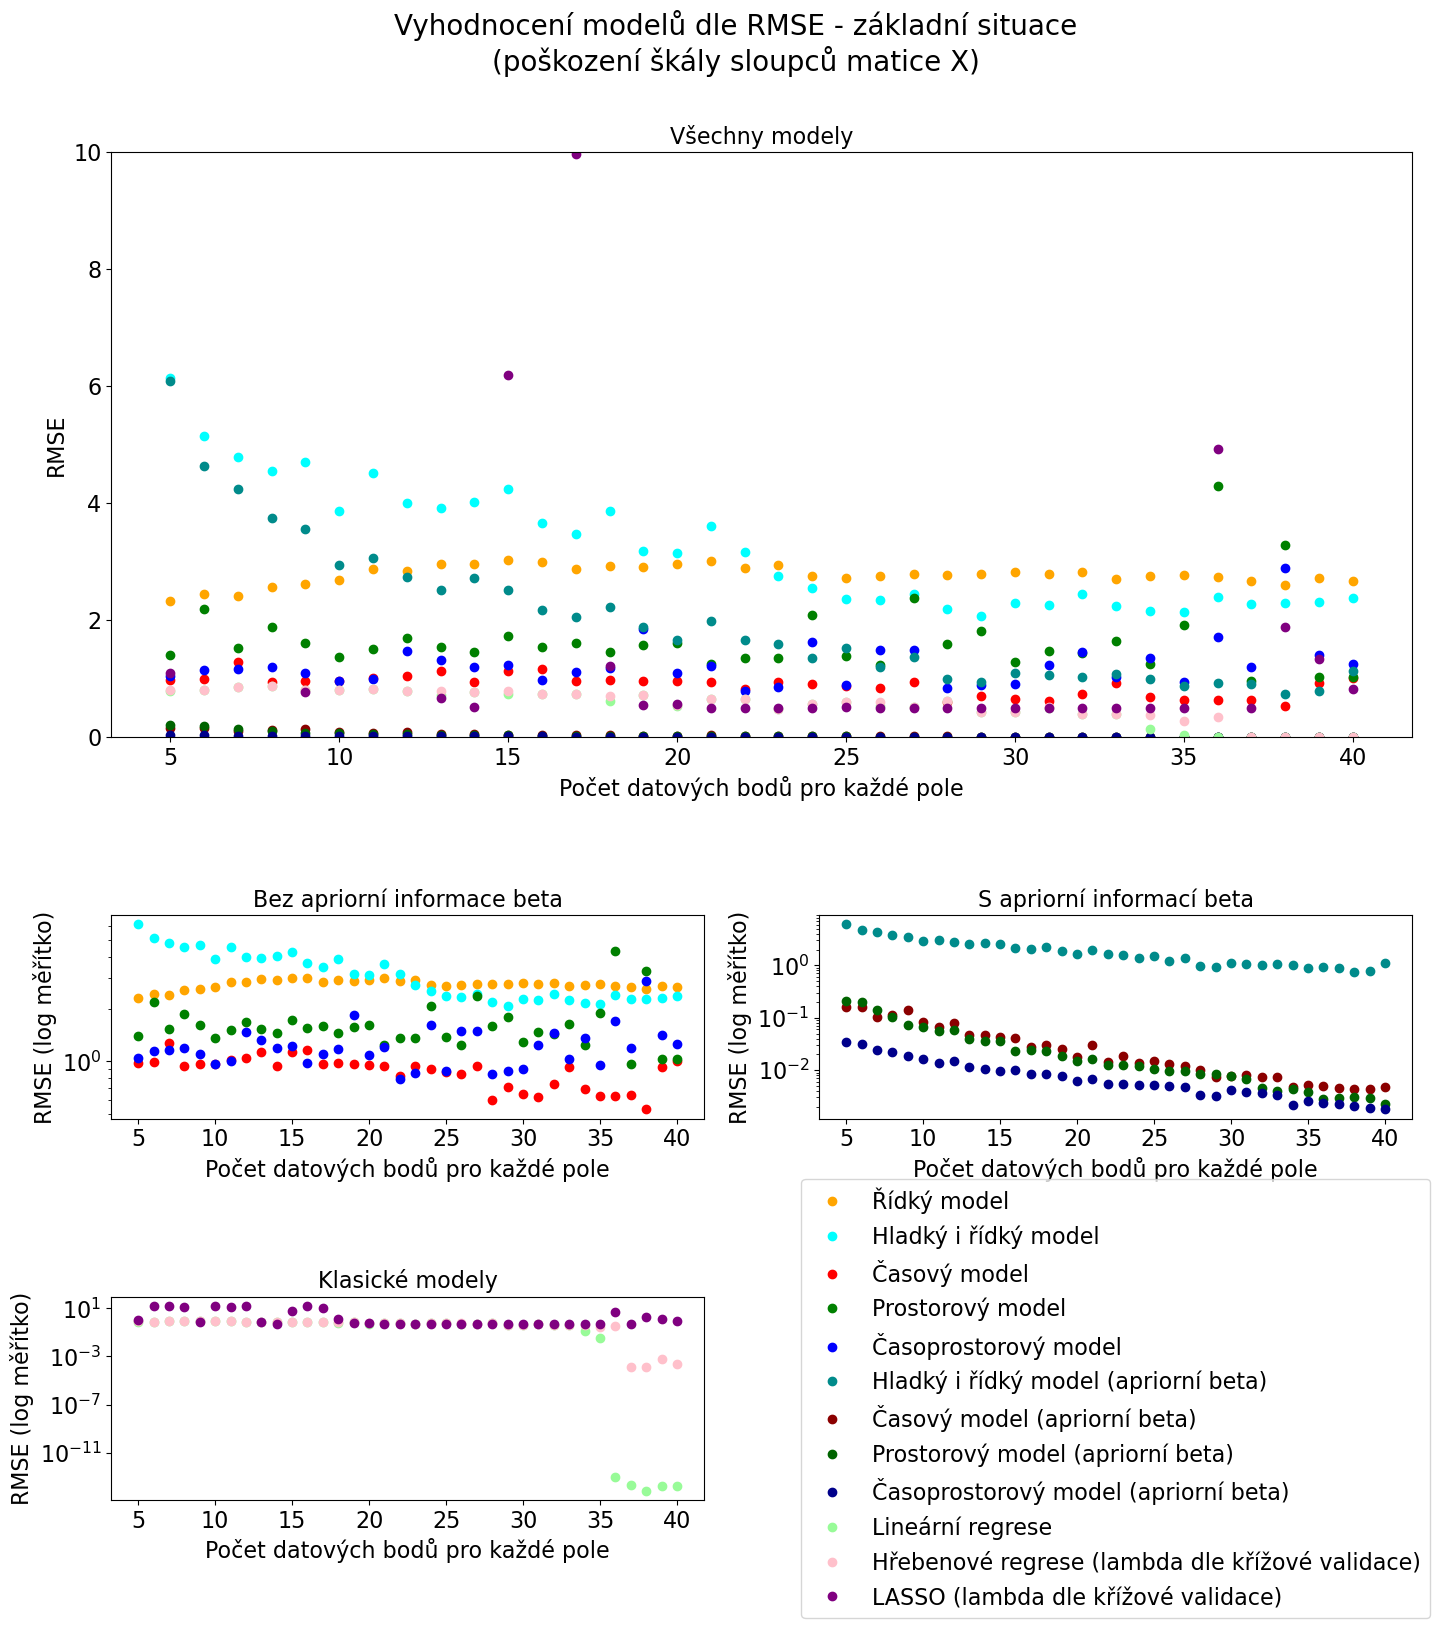

In [17]:
noiseSigma = 0
damaged = True
dropColumn = False
plotTitle = "základní situace\n(poškození škály sloupců matice X)"
fileTitle = "Situation1Scale"
RunAllSimulations(noiseSigma, damaged, dropColumn, maxData = maxData, seed = 40693057, repeat=0, ylimSet=10, plotTitle=plotTitle, fileTitle=fileTitle)

Lineární regrese - RMSE: 0.763
Hřebenová regrese - RMSE: 0.763
LASSO - RMSE: 0.513
Řídký model - RMSE: 2.954
Hladký i řídký model - RMSE: 4.019
Časový model - RMSE: 0.934
Prostorový model - RMSE: 1.461
Časoprostorový model - RMSE: 1.197
Hladký i řídký model (apriorní emise) - RMSE: 2.714
Časový model (apriorní emise) - RMSE: 0.047
Prostorový model (apriorní emise) - RMSE: 0.036
Časoprostorový model (apriorní emise) - RMSE: 0.011


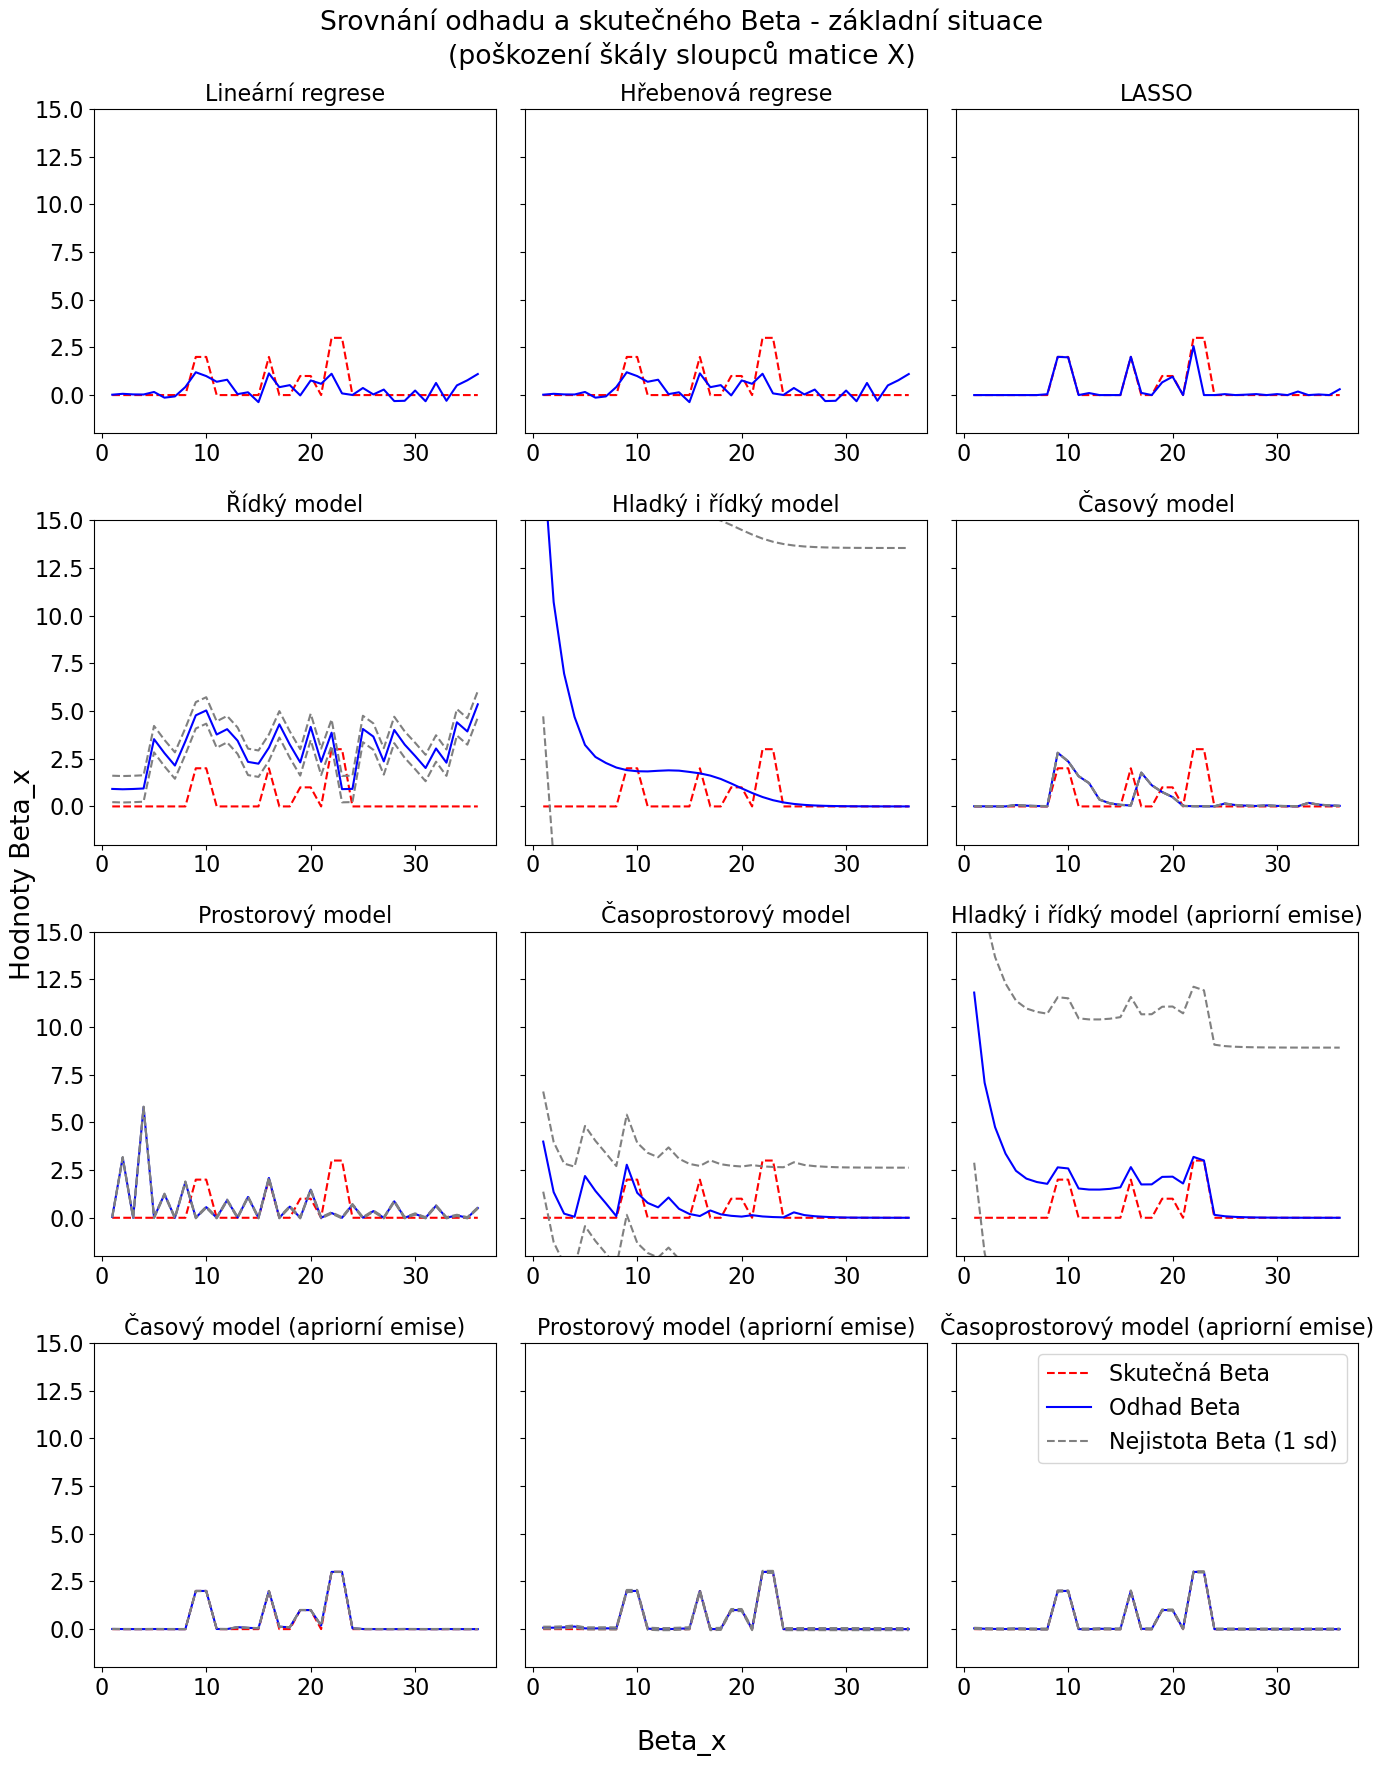

In [18]:
X,y,beta_true = generateData(14, sMatrix, sigma=noiseSigma, damageData=damaged, dropColumn=dropColumn)
plotExperiment(X, y, beta_true, plotTitle=plotTitle, fileTitle=fileTitle)

### Test 4 - odebrání významného sloupce

- Bez šumu
- Bez poškození matice X
- Výpadek sloupce s indexem 9 (odpovídá třetímu políčku v čase t1)

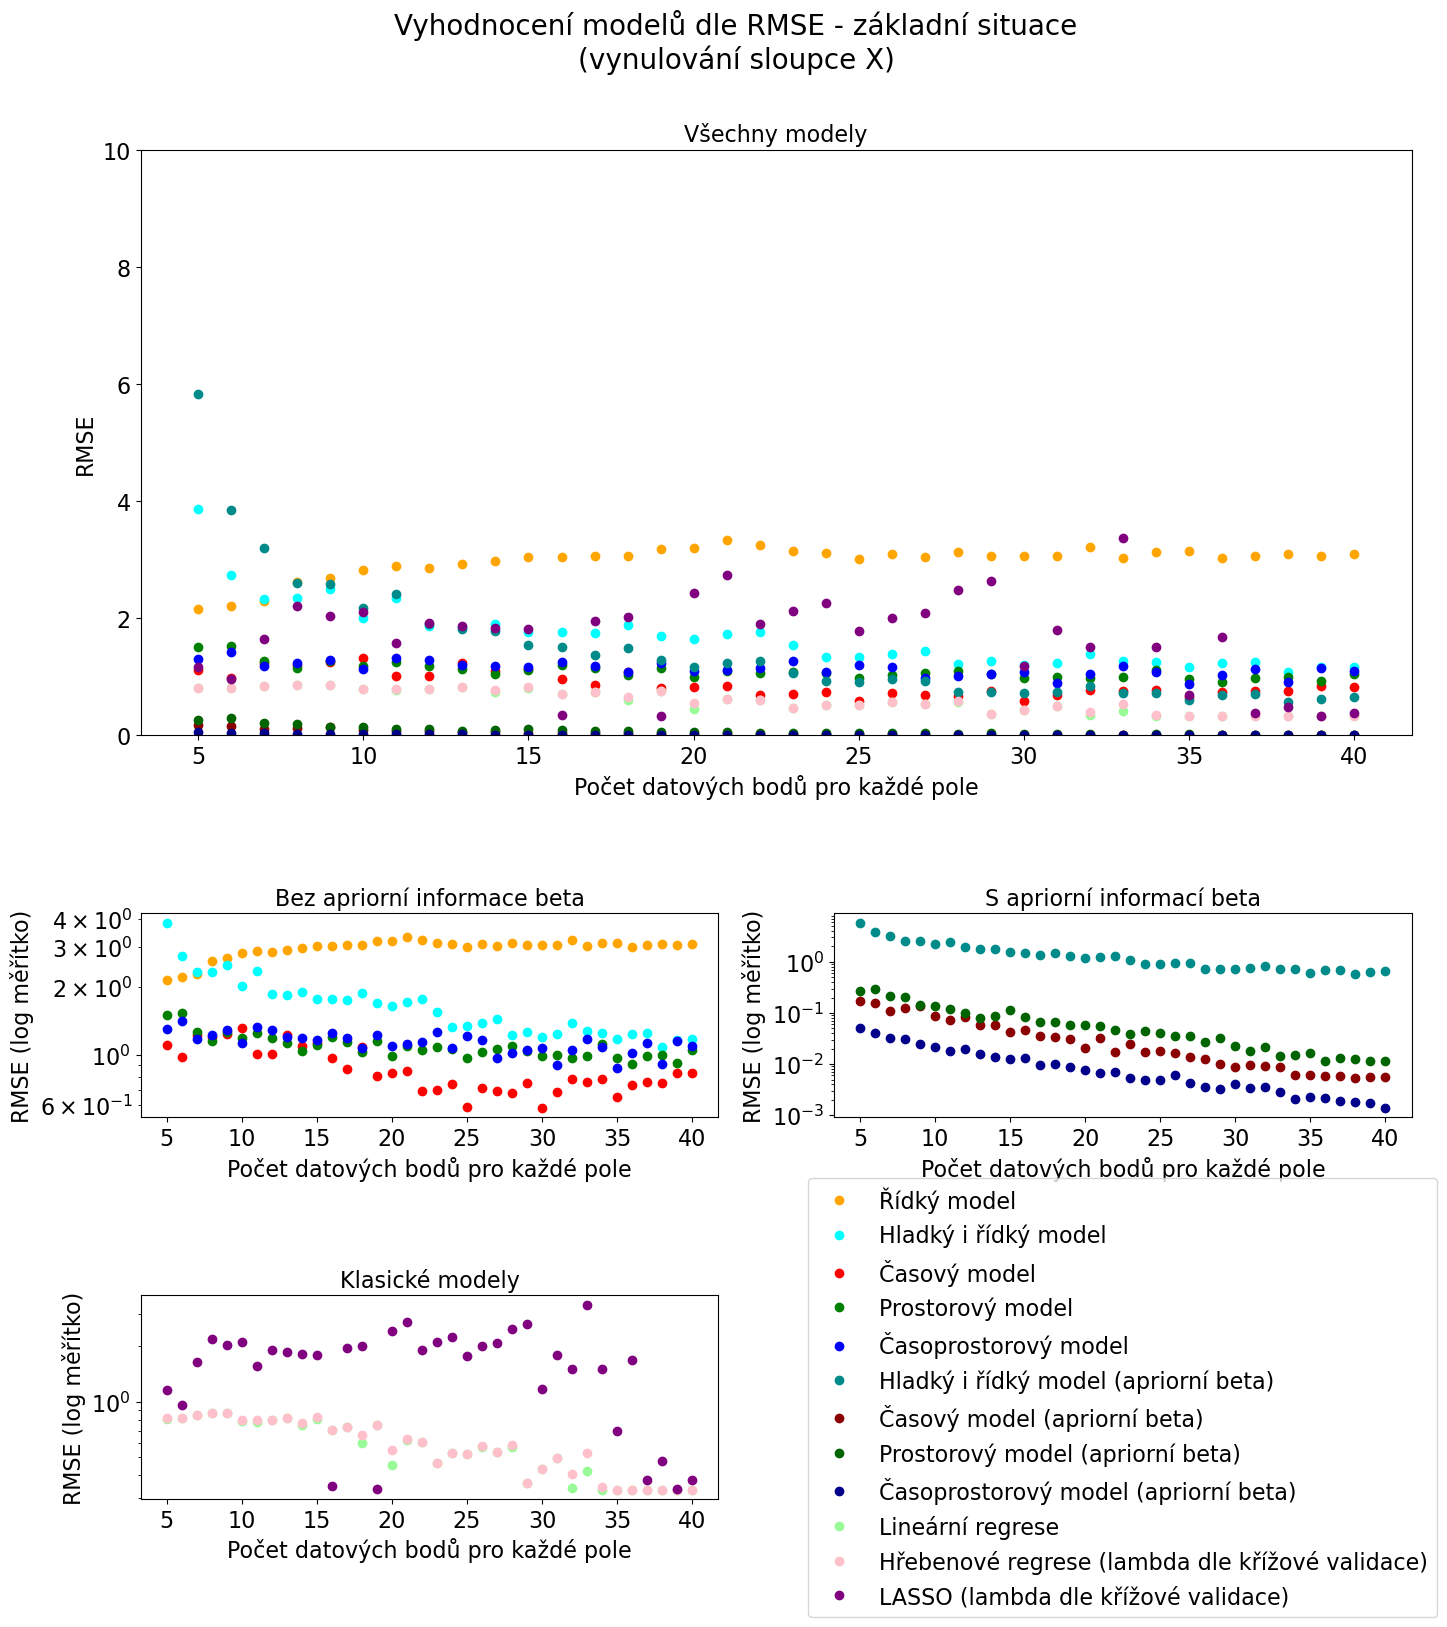

In [19]:
noiseSigma = 0
damaged = False
dropColumn = True
plotTitle = "základní situace\n(vynulování sloupce X)"
fileTitle = "Situation1ZeroColumn"
RunAllSimulations(noiseSigma, damaged, dropColumn, maxData = maxData, seed = 40693057, repeat=0, plotTitle=plotTitle, fileTitle=fileTitle)

Lineární regrese - RMSE: 0.746
Hřebenová regrese - RMSE: 0.769
LASSO - RMSE: 1.830
Řídký model - RMSE: 2.977
Hladký i řídký model - RMSE: 1.902
Časový model - RMSE: 1.092
Prostorový model - RMSE: 1.044
Časoprostorový model - RMSE: 1.191
Hladký i řídký model (apriorní emise) - RMSE: 1.783
Časový model (apriorní emise) - RMSE: 0.058
Prostorový model (apriorní emise) - RMSE: 0.086
Časoprostorový model (apriorní emise) - RMSE: 0.014


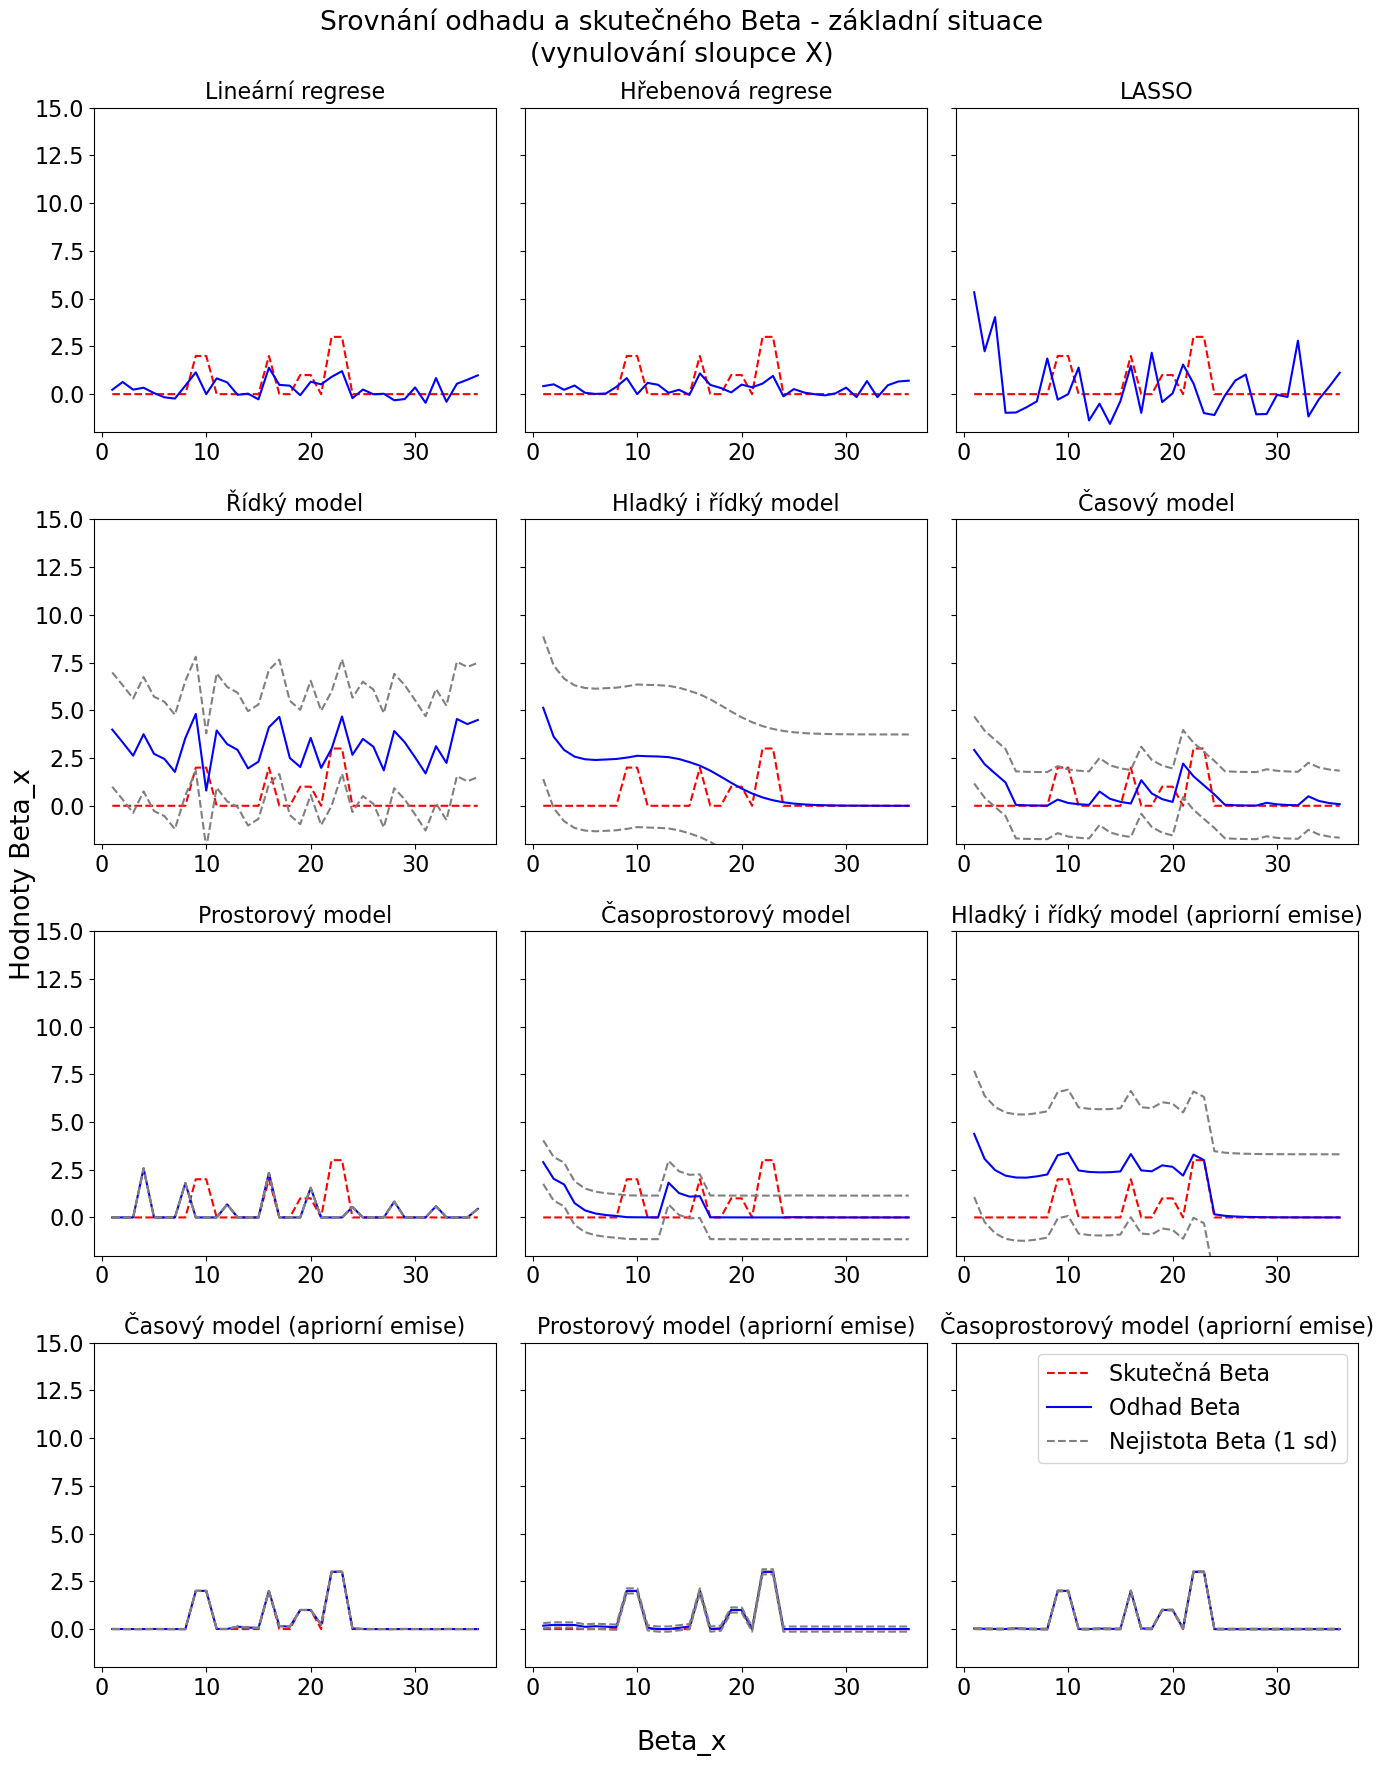

In [20]:
X,y,beta_true = generateData(14, sMatrix, sigma=noiseSigma, damageData=damaged, dropColumn=dropColumn)
plotExperiment(X, y, beta_true, plotTitle=plotTitle, fileTitle=fileTitle)

### Test 5 - obecný test

- Šum: $\sigma$ = 5
- V matici X byly přeškálovany (vyděleny 10) sloupce odpovídající:
    - prvnímu políčku (všechny časy);
    - časy `t2`, `t3` na pátém políčku.  
- Výpadek významného sloupce 9 (políčko 3 v čase `t1`)

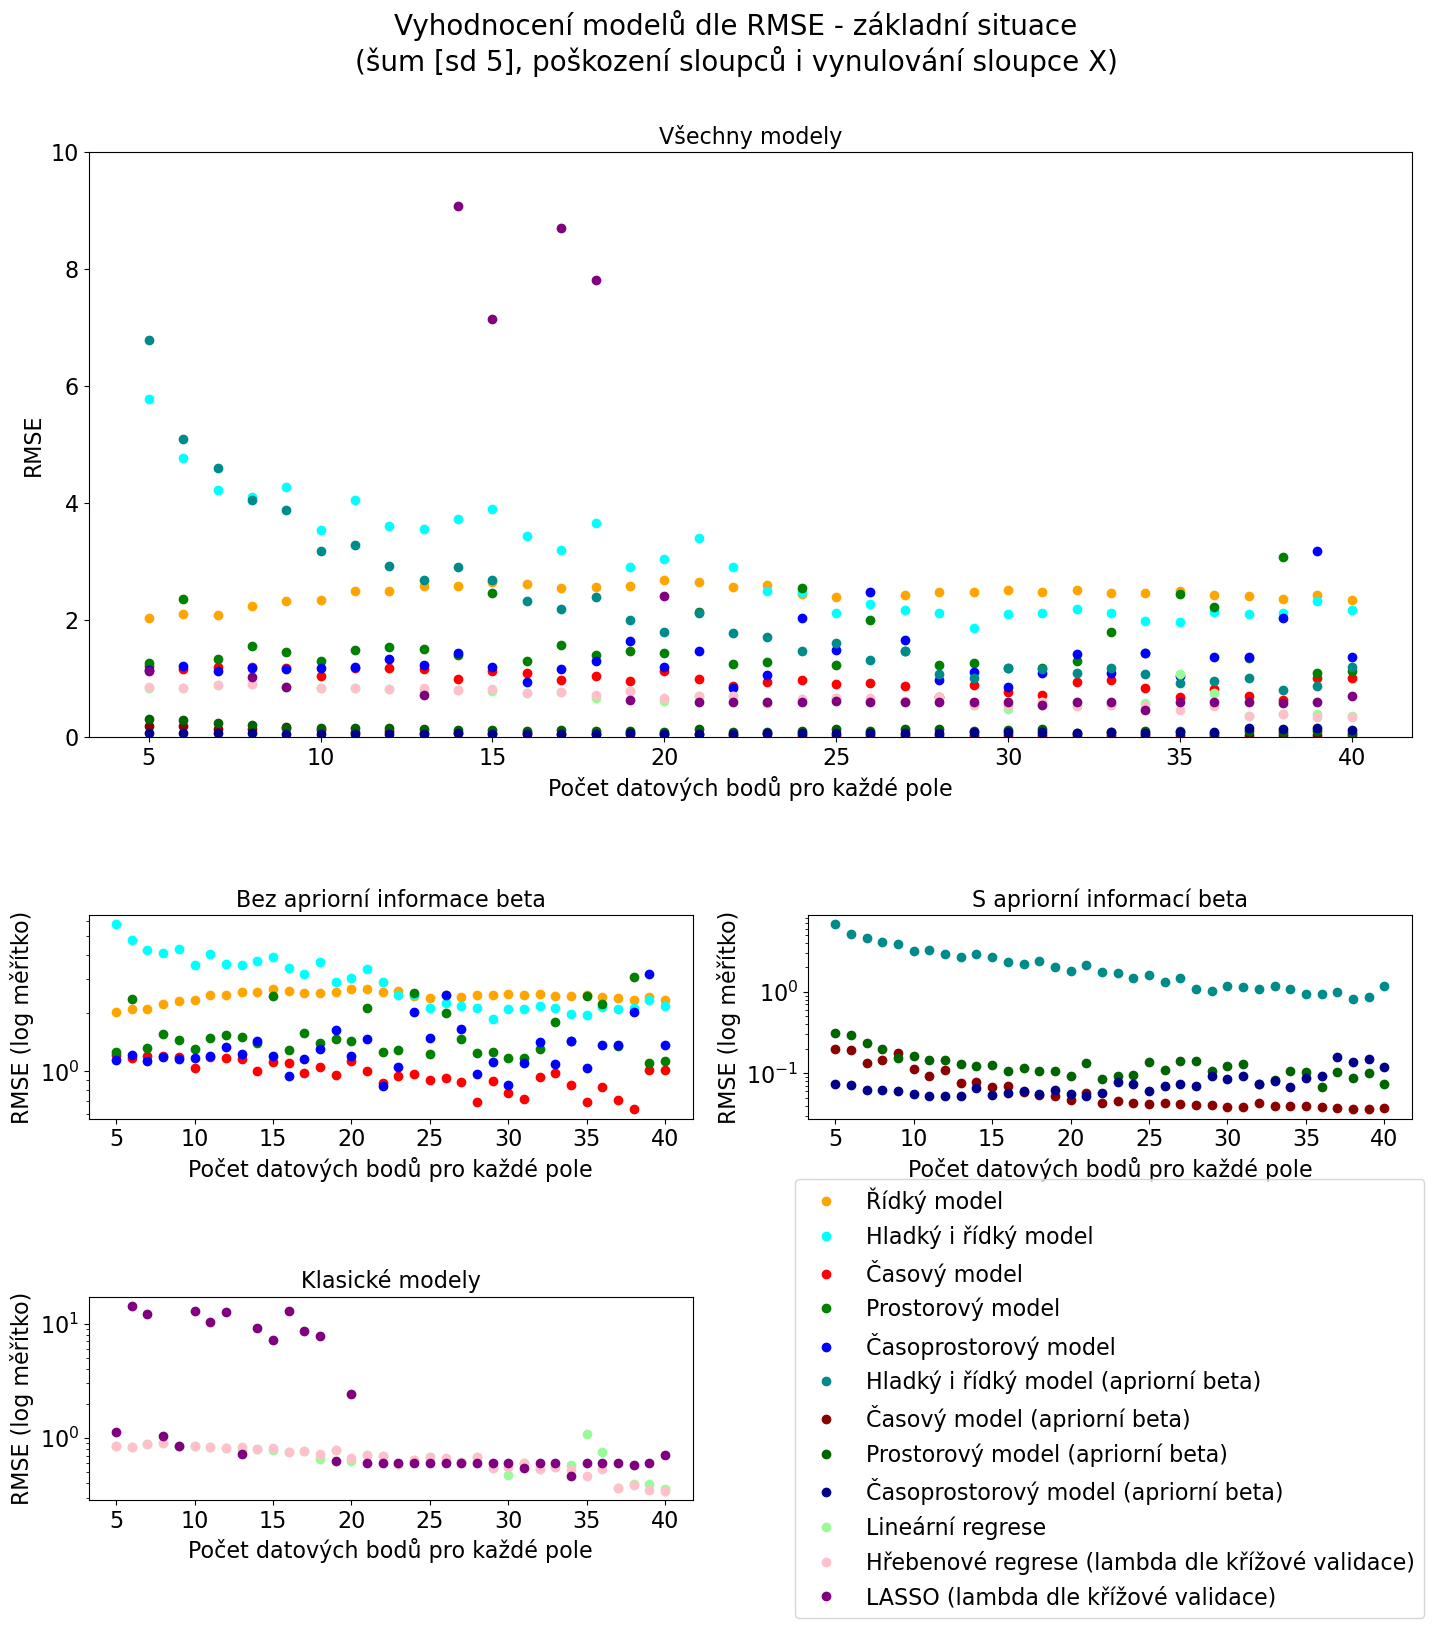

In [21]:
noiseSigma = 5
damaged = True
dropColumn = True
plotTitle = "základní situace\n(šum [sd 5], poškození sloupců i vynulování sloupce X)"
fileTitle = "Situation1General"
RunAllSimulations(noiseSigma, damaged, dropColumn, maxData=maxData, seed=40693057, repeat=0, plotTitle=plotTitle, fileTitle=fileTitle)

Lineární regrese - RMSE: 0.804
Hřebenová regrese - RMSE: 0.804
LASSO - RMSE: 9.073
Řídký model - RMSE: 2.577
Hladký i řídký model - RMSE: 3.724
Časový model - RMSE: 0.998
Prostorový model - RMSE: 1.400
Časoprostorový model - RMSE: 1.430
Hladký i řídký model (apriorní emise) - RMSE: 2.910
Časový model (apriorní emise) - RMSE: 0.077
Prostorový model (apriorní emise) - RMSE: 0.123
Časoprostorový model (apriorní emise) - RMSE: 0.066


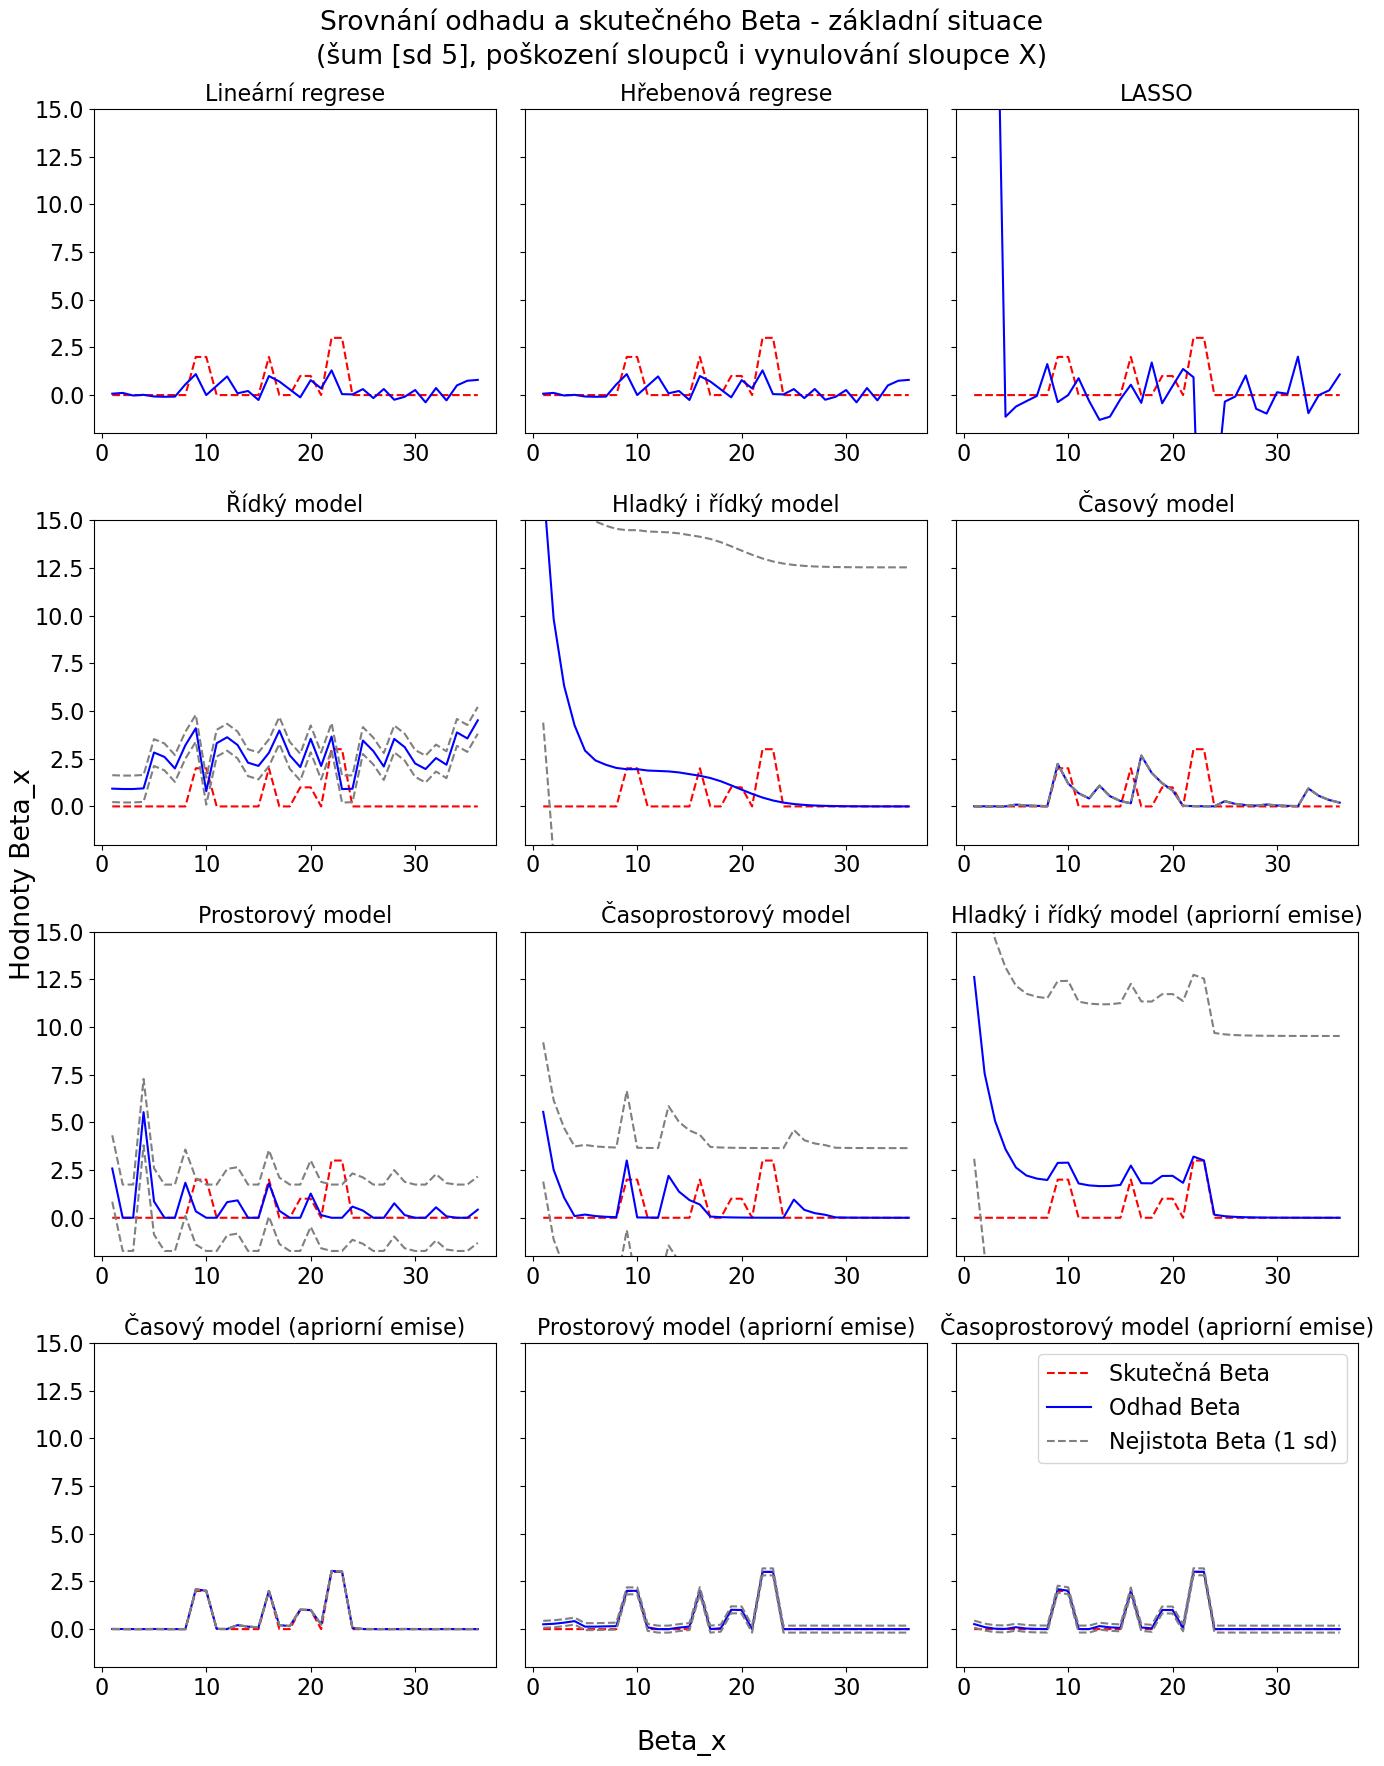

In [22]:
X,y,beta_true = generateData(14, sMatrix, sigma=noiseSigma, damageData=damaged, dropColumn=dropColumn)
plotExperiment(X, y, beta_true, plotTitle=plotTitle, fileTitle=fileTitle)

## Situace 2 - méně řídká struktura

Druhá série testů proběhne na jiné matici `sMatrix`, která méně řídká než původní (0 nahrazeny za stopové 0.5).

In [23]:
sMatrix = np.matrix(
    [
        [0,0,0,0.5],
        [0.5,0.5,0.5,0.5],
        [2,2,0.5,0],
        
        [0,0,0.5,2],
        [0,0.5,1,1],
        [0.5,3,3,0.5],
        
        [0,0,0.5,0.5],
        [0,0,0.5,0.5],
        [0,0.5,0.5,0]
    ])

### Test 1 - obecný test

- Šum: $\sigma$ = 5
- V matici X byly přeškálovany (vyděleny 10) sloupce odpovídající:
    - prvnímu políčku (všechny časy);
    - časy `t2`, `t3` na pátém políčku.  
- Výpadek významného sloupce 9 (políčko 3 v čase `t1`)

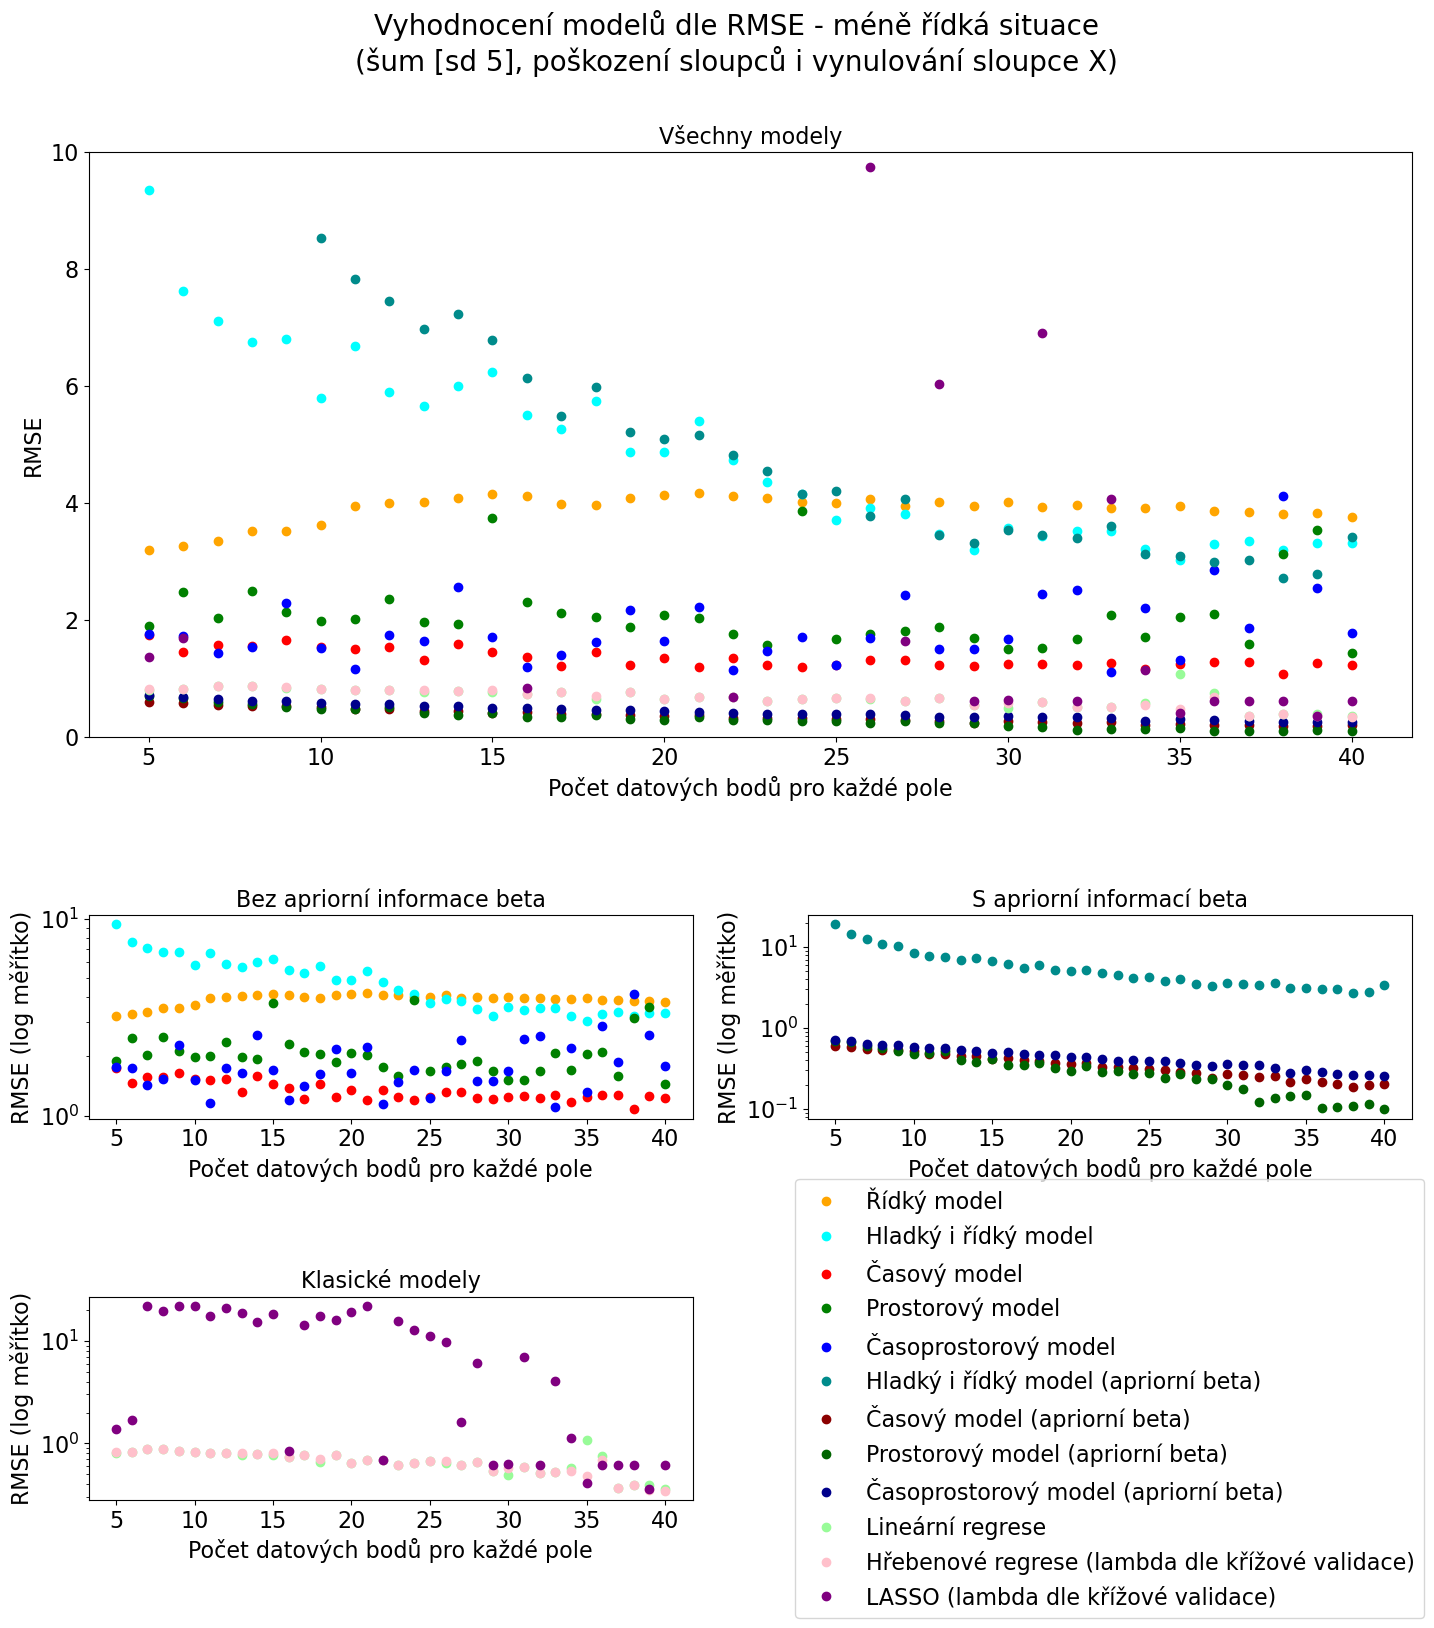

In [24]:
noiseSigma = 5
damaged = True
dropColumn = True
plotTitle = "méně řídká situace\n(šum [sd 5], poškození sloupců i vynulování sloupce X)"
fileTitle = "Situation2General"
RunAllSimulations(noiseSigma, damaged, dropColumn, maxData=maxData, seed=40693057, repeat=0, plotTitle=plotTitle, fileTitle=fileTitle)

Lineární regrese - RMSE: 0.790
Hřebenová regrese - RMSE: 0.790
LASSO - RMSE: 15.110
Řídký model - RMSE: 4.088
Hladký i řídký model - RMSE: 6.003
Časový model - RMSE: 1.584
Prostorový model - RMSE: 1.941
Časoprostorový model - RMSE: 2.570
Hladký i řídký model (apriorní emise) - RMSE: 7.236
Časový model (apriorní emise) - RMSE: 0.445
Prostorový model (apriorní emise) - RMSE: 0.377
Časoprostorový model (apriorní emise) - RMSE: 0.523


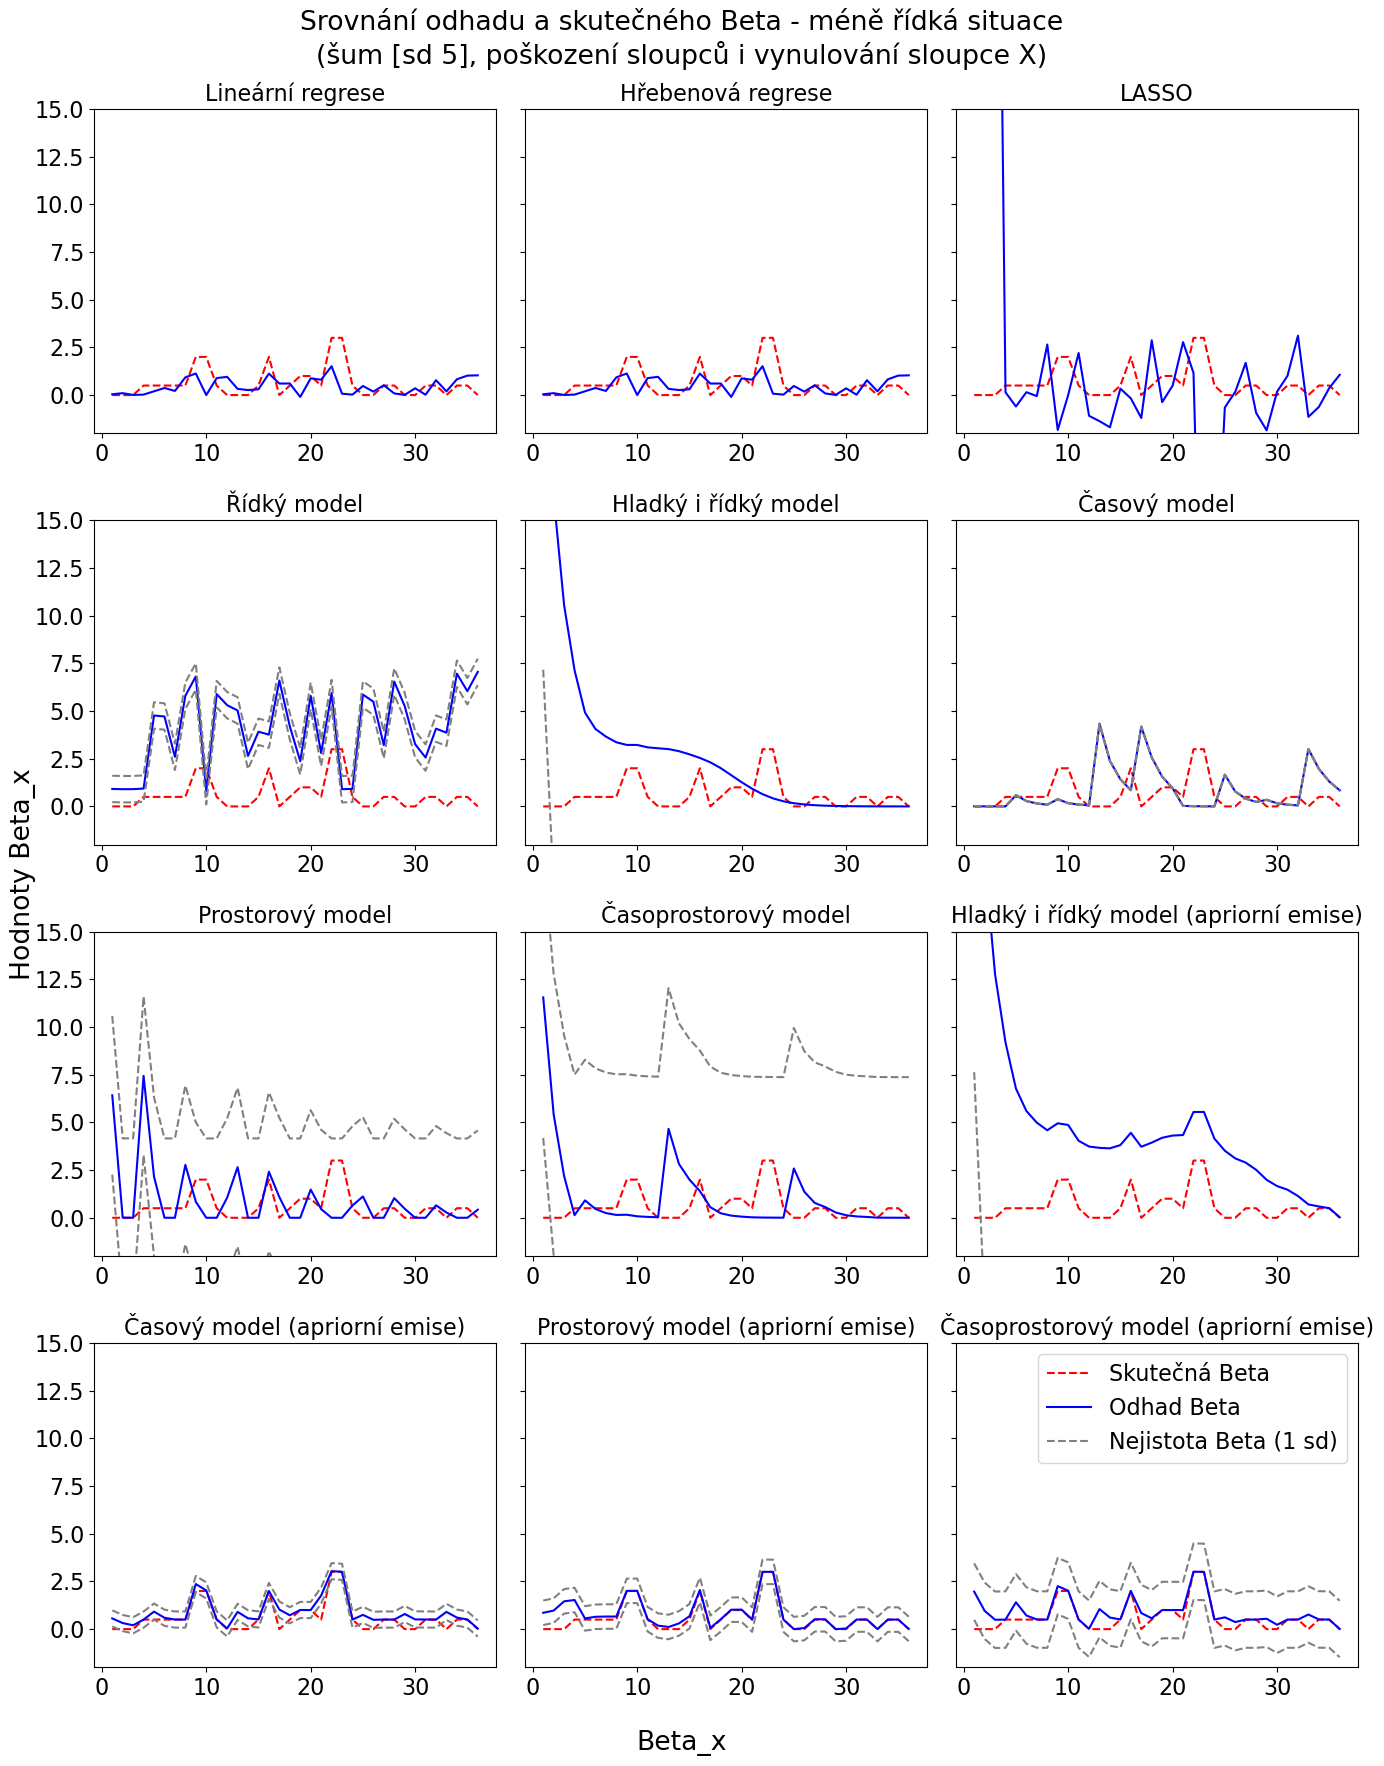

In [25]:
X,y,beta_true = generateData(14, sMatrix, sigma=noiseSigma, damageData=damaged, dropColumn=dropColumn)
plotExperiment(X, y, beta_true, plotTitle=plotTitle, fileTitle=fileTitle)

## Situace 3 - více požárů

Třetí řada testů proběhne na jiné matici `sMatrix`.

Zde je problém zjednodušen na odhadování pouze indikátoru požáru (0 nebo 1). Za to je `sMatrix` méně řídká.

Data reprezentují situaci, kde se požár rozšiřoval na sousední políčka s tím, že začal na políčku 6 a 9 (indexováno z levého horního rohu počínaje 1).

In [26]:
sMatrix = np.matrix(
    [
        [0,0,0,0], # 0
        [0,0,1,0], # 4
        [0,1,1,0], # 8
        
        [0,0,1,1], # 12
        [0,1,1,1], # 16
        [1,1,1,0], # 20
        
        [0,0,1,0], # 24
        [0,1,1,1], # 28
        [1,1,1,0] # 32
    ])

### Test 1 - obecný test

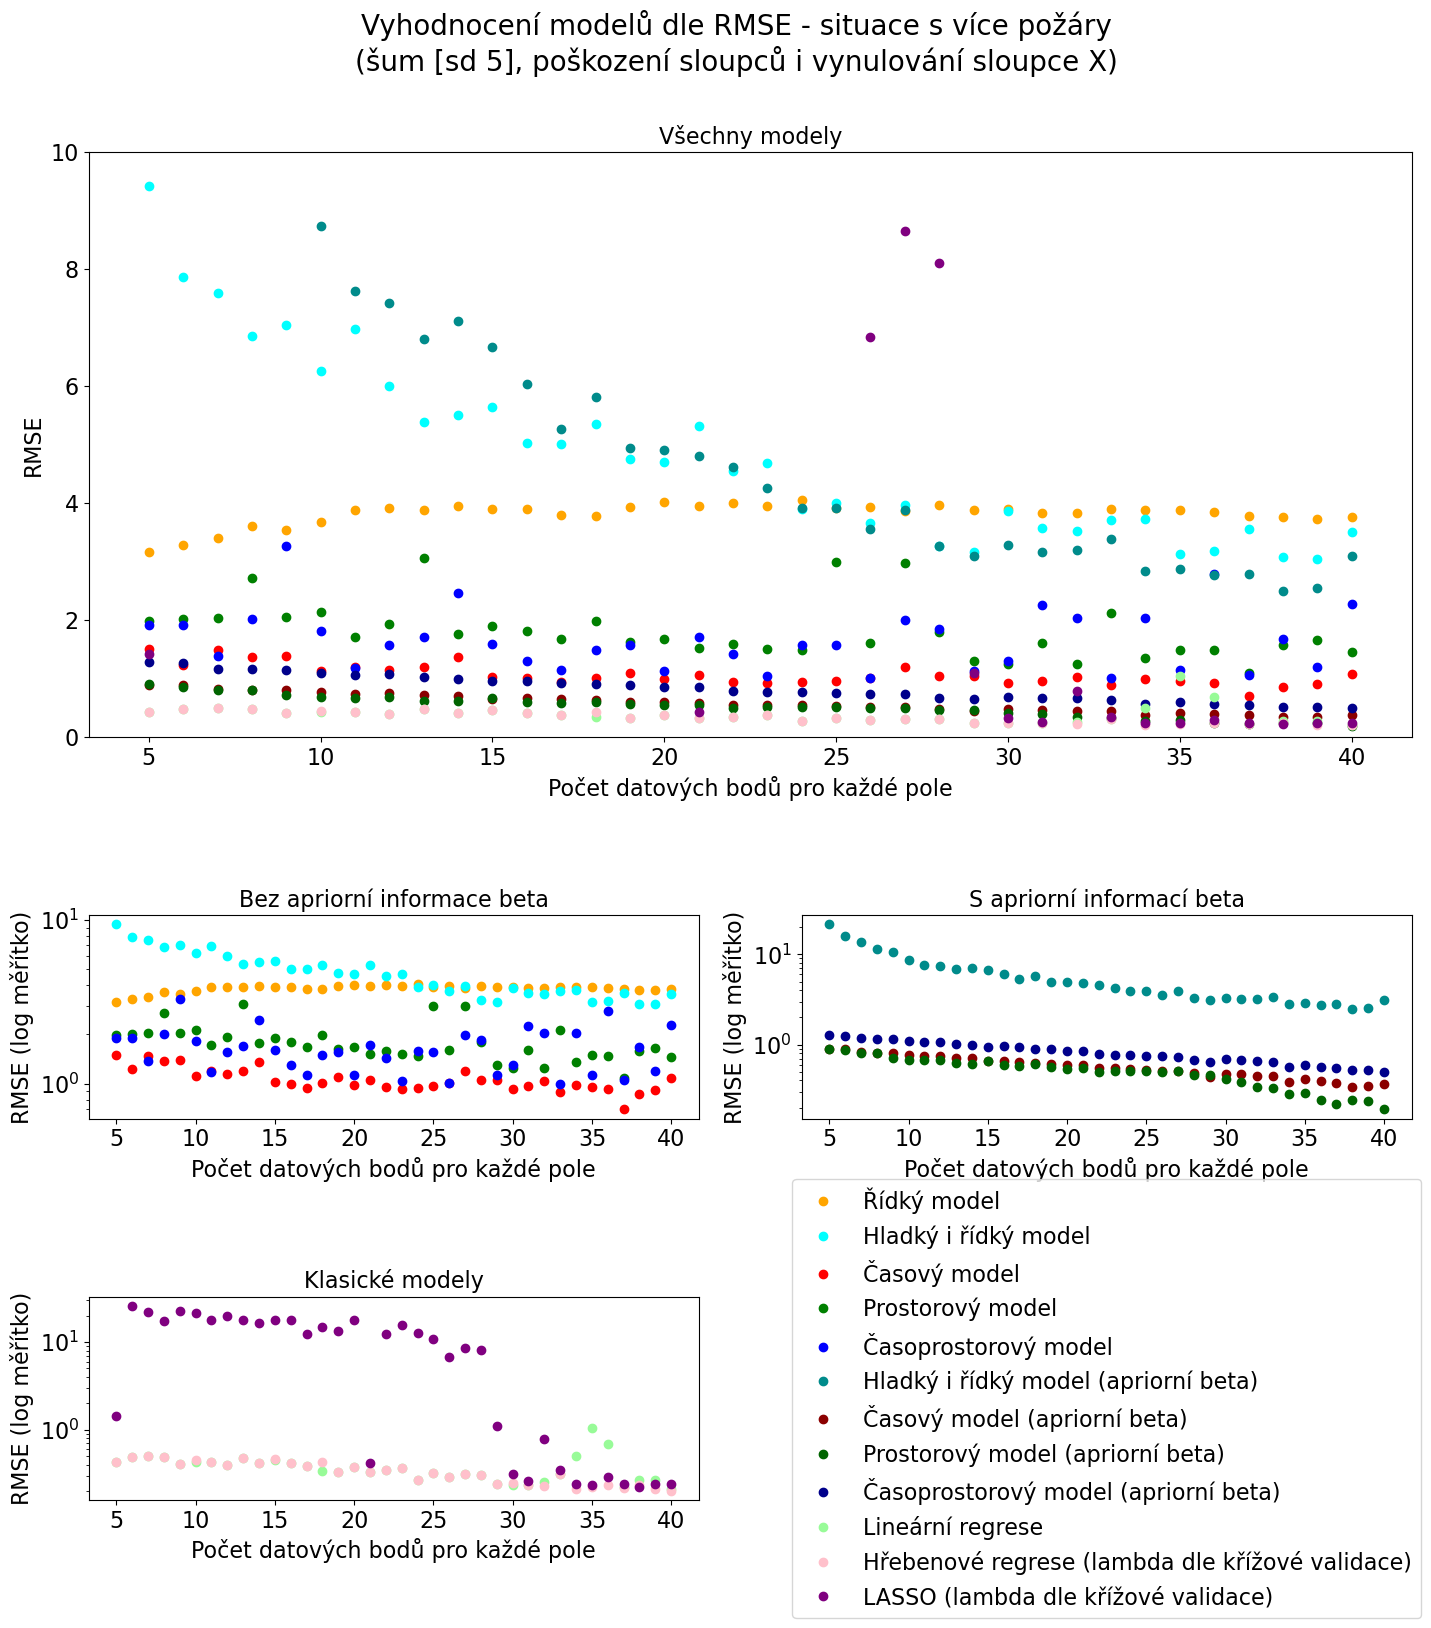

In [27]:
noiseSigma = 5
damaged = True
dropColumn = True
plotTitle = "situace s více požáry\n(šum [sd 5], poškození sloupců i vynulování sloupce X)"
fileTitle = "Situation3General"
RunAllSimulations(noiseSigma, damaged, dropColumn, maxData=maxData, seed=40693057, repeat=0, plotTitle=plotTitle, fileTitle=fileTitle)

Lineární regrese - RMSE: 0.418
Hřebenová regrese - RMSE: 0.418
LASSO - RMSE: 16.346
Řídký model - RMSE: 3.955
Hladký i řídký model - RMSE: 5.512
Časový model - RMSE: 1.362
Prostorový model - RMSE: 1.766
Časoprostorový model - RMSE: 2.460
Hladký i řídký model (apriorní emise) - RMSE: 7.110
Časový model (apriorní emise) - RMSE: 0.702
Prostorový model (apriorní emise) - RMSE: 0.609
Časoprostorový model (apriorní emise) - RMSE: 1.000


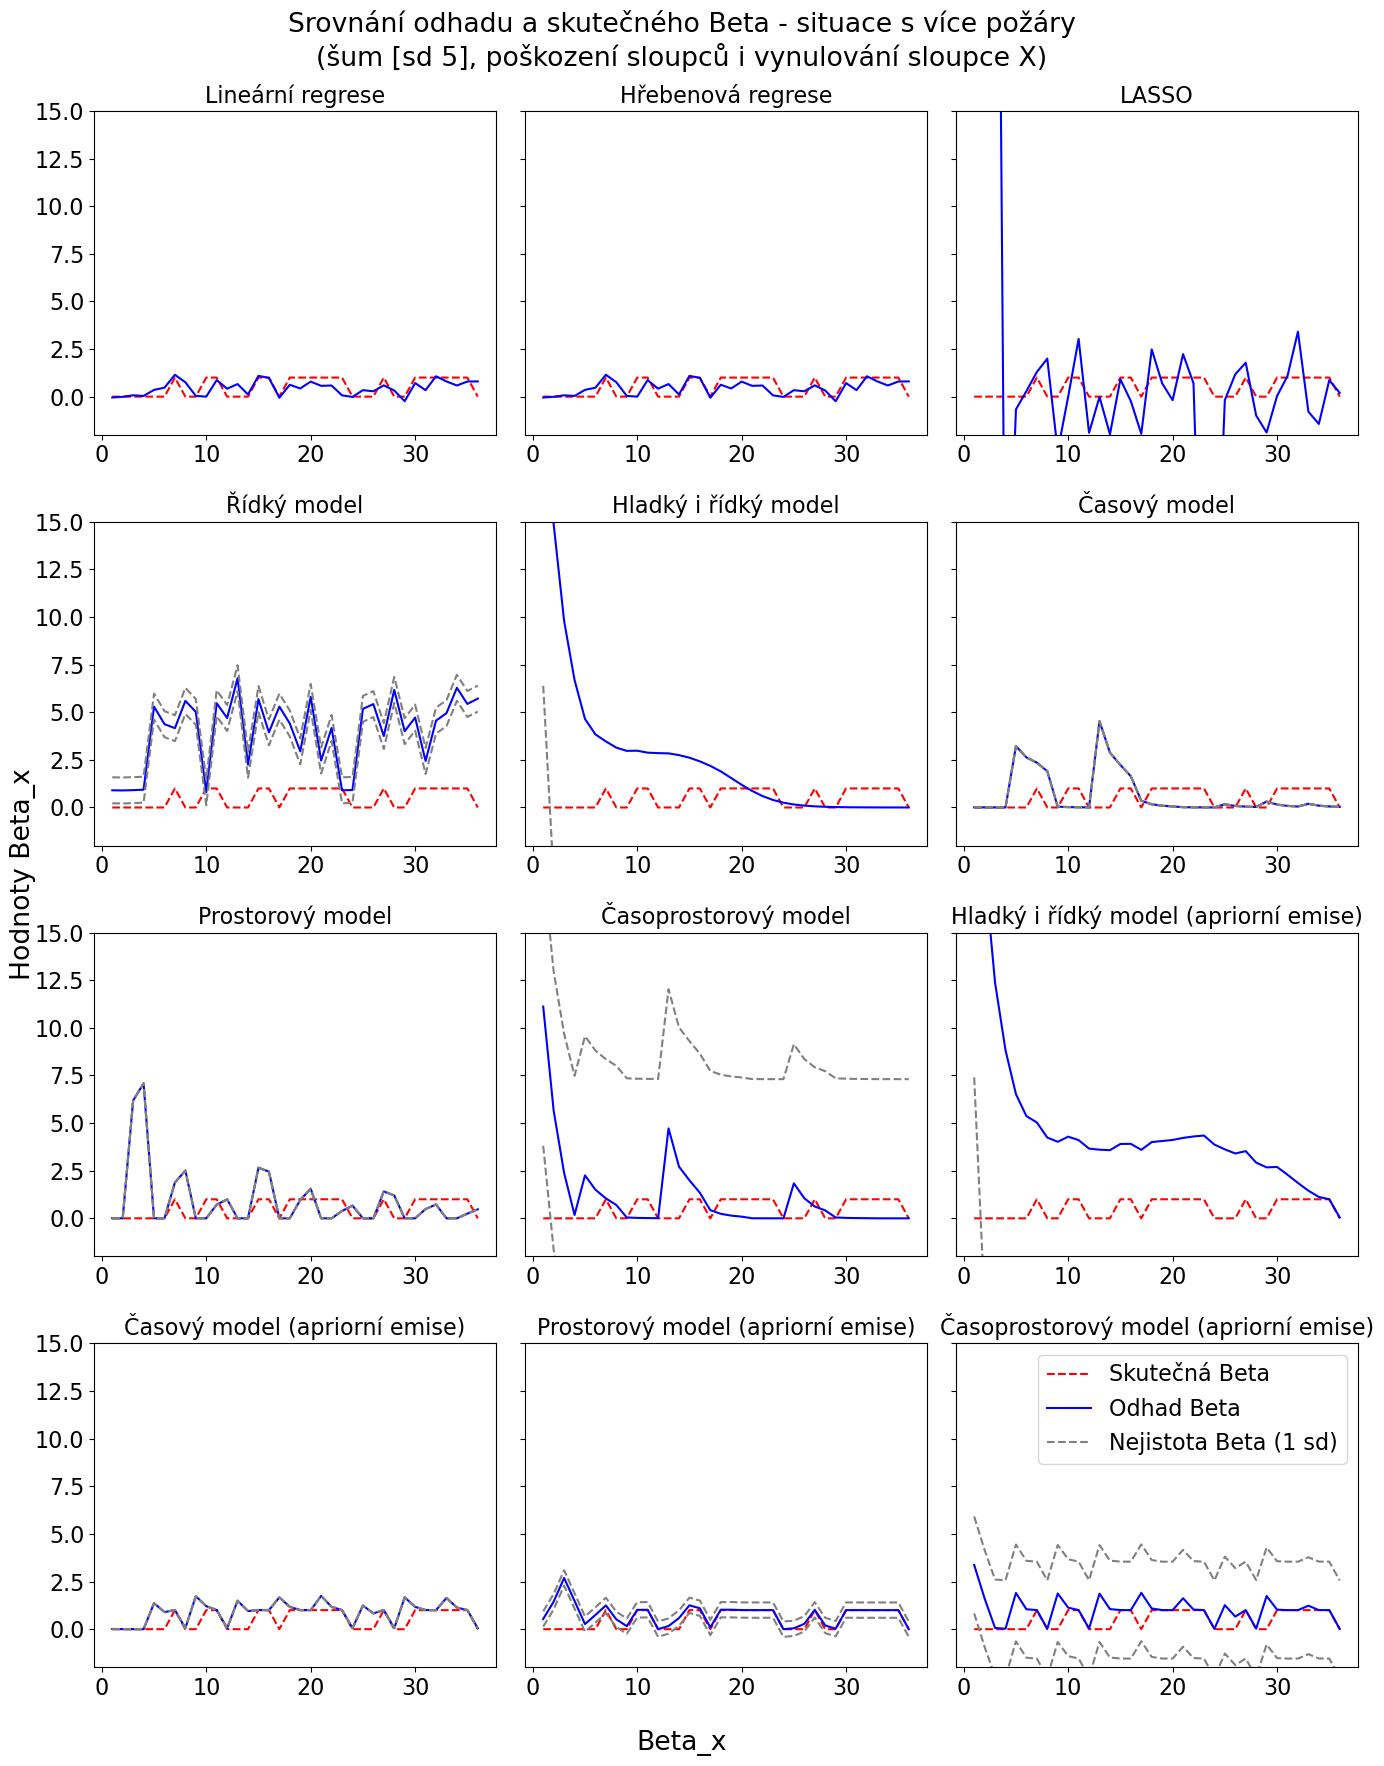

In [28]:
X,y,beta_true = generateData(14, sMatrix, sigma=noiseSigma, damageData=damaged, dropColumn=dropColumn)
plotExperiment(X, y, beta_true, plotTitle=plotTitle, fileTitle=fileTitle)

## Situace 4 - explicitní časoprostorová závislost

Situace 4 byla zvolena, aby co nejvíce odpovídala běžné situaci.

Struktura `sMatrix` reprezentuje počátek požáru na políčku 7 ze kterého se šířil do sousedních políček vždy s poloviční intenzitou (prostorová závislost). Zároveň, intenzita vždy klesne o 1 s časem (časová závislost).

Struktura je zvone tak, aby představovala dokonalou situaci pro časoprostorový model. Tedy, časoprostorový model by se měl chovat na těchto datech nejlépe. 

In [29]:
sMatrix = np.matrix(
    [
        [0,0,1,0],
        [0,0,0,1],
        [0,0,0,0],
        
        [0,2,1,0],
        [0,0,1,0],
        [0,0,0,1],
        
        [4,3,2,1],
        [0,2,1,0],
        [0,0,1,0]
    ])

### Test 1 - obecný test

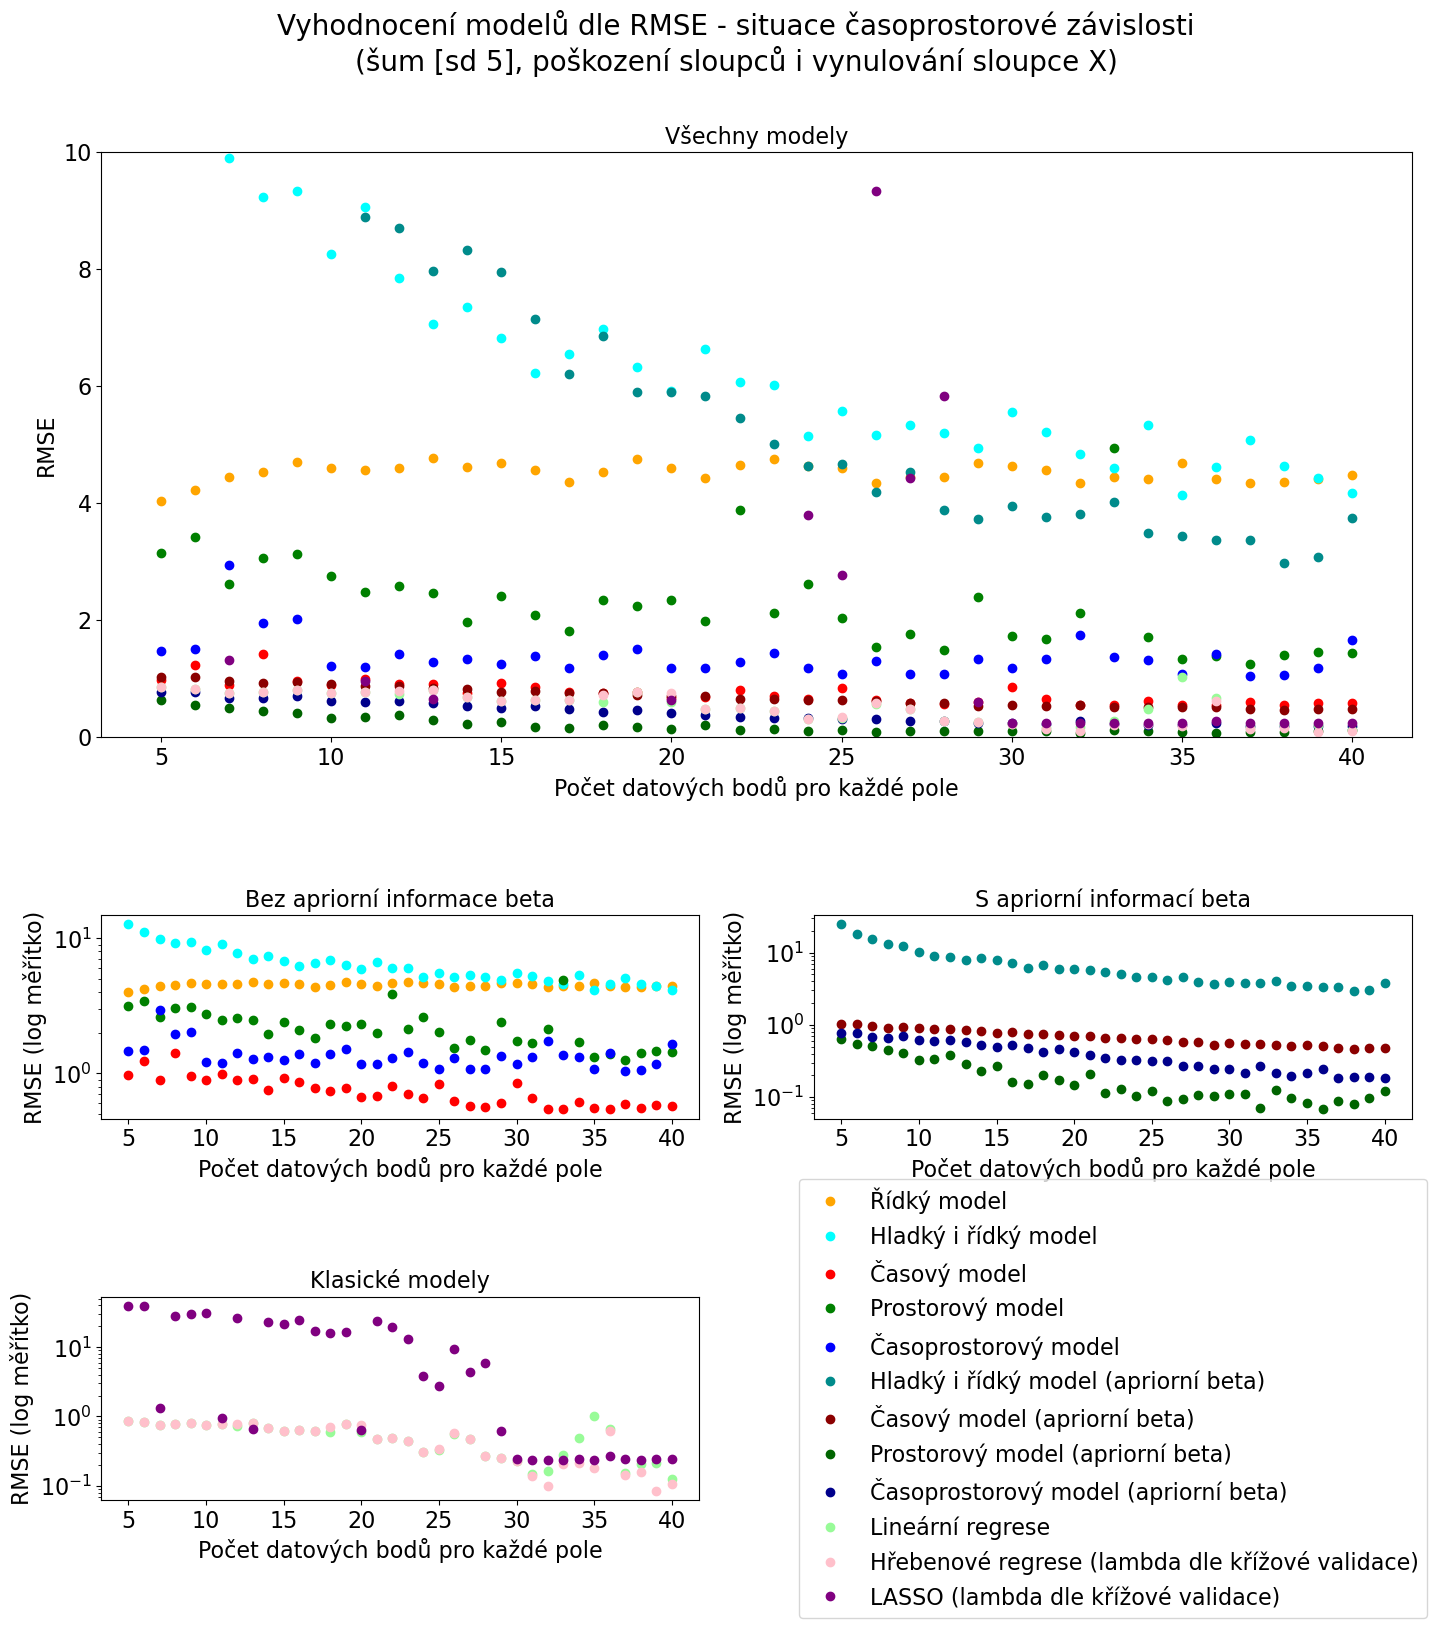

In [30]:
noiseSigma = 5
damaged = True
dropColumn = True
plotTitle = "situace časoprostorové závislosti\n(šum [sd 5], poškození sloupců i vynulování sloupce X)"
fileTitle = "Situation4General"
RunAllSimulations(noiseSigma, damaged, dropColumn, maxData=maxData, seed=40693057, repeat=0, plotTitle=plotTitle, fileTitle=fileTitle)

Lineární regrese - RMSE: 0.689
Hřebenová regrese - RMSE: 0.689
LASSO - RMSE: 23.009
Řídký model - RMSE: 4.618
Hladký i řídký model - RMSE: 7.353
Časový model - RMSE: 0.750
Prostorový model - RMSE: 1.971
Časoprostorový model - RMSE: 1.327
Hladký i řídký model (apriorní emise) - RMSE: 8.329
Časový model (apriorní emise) - RMSE: 0.827
Prostorový model (apriorní emise) - RMSE: 0.227
Časoprostorový model (apriorní emise) - RMSE: 0.527


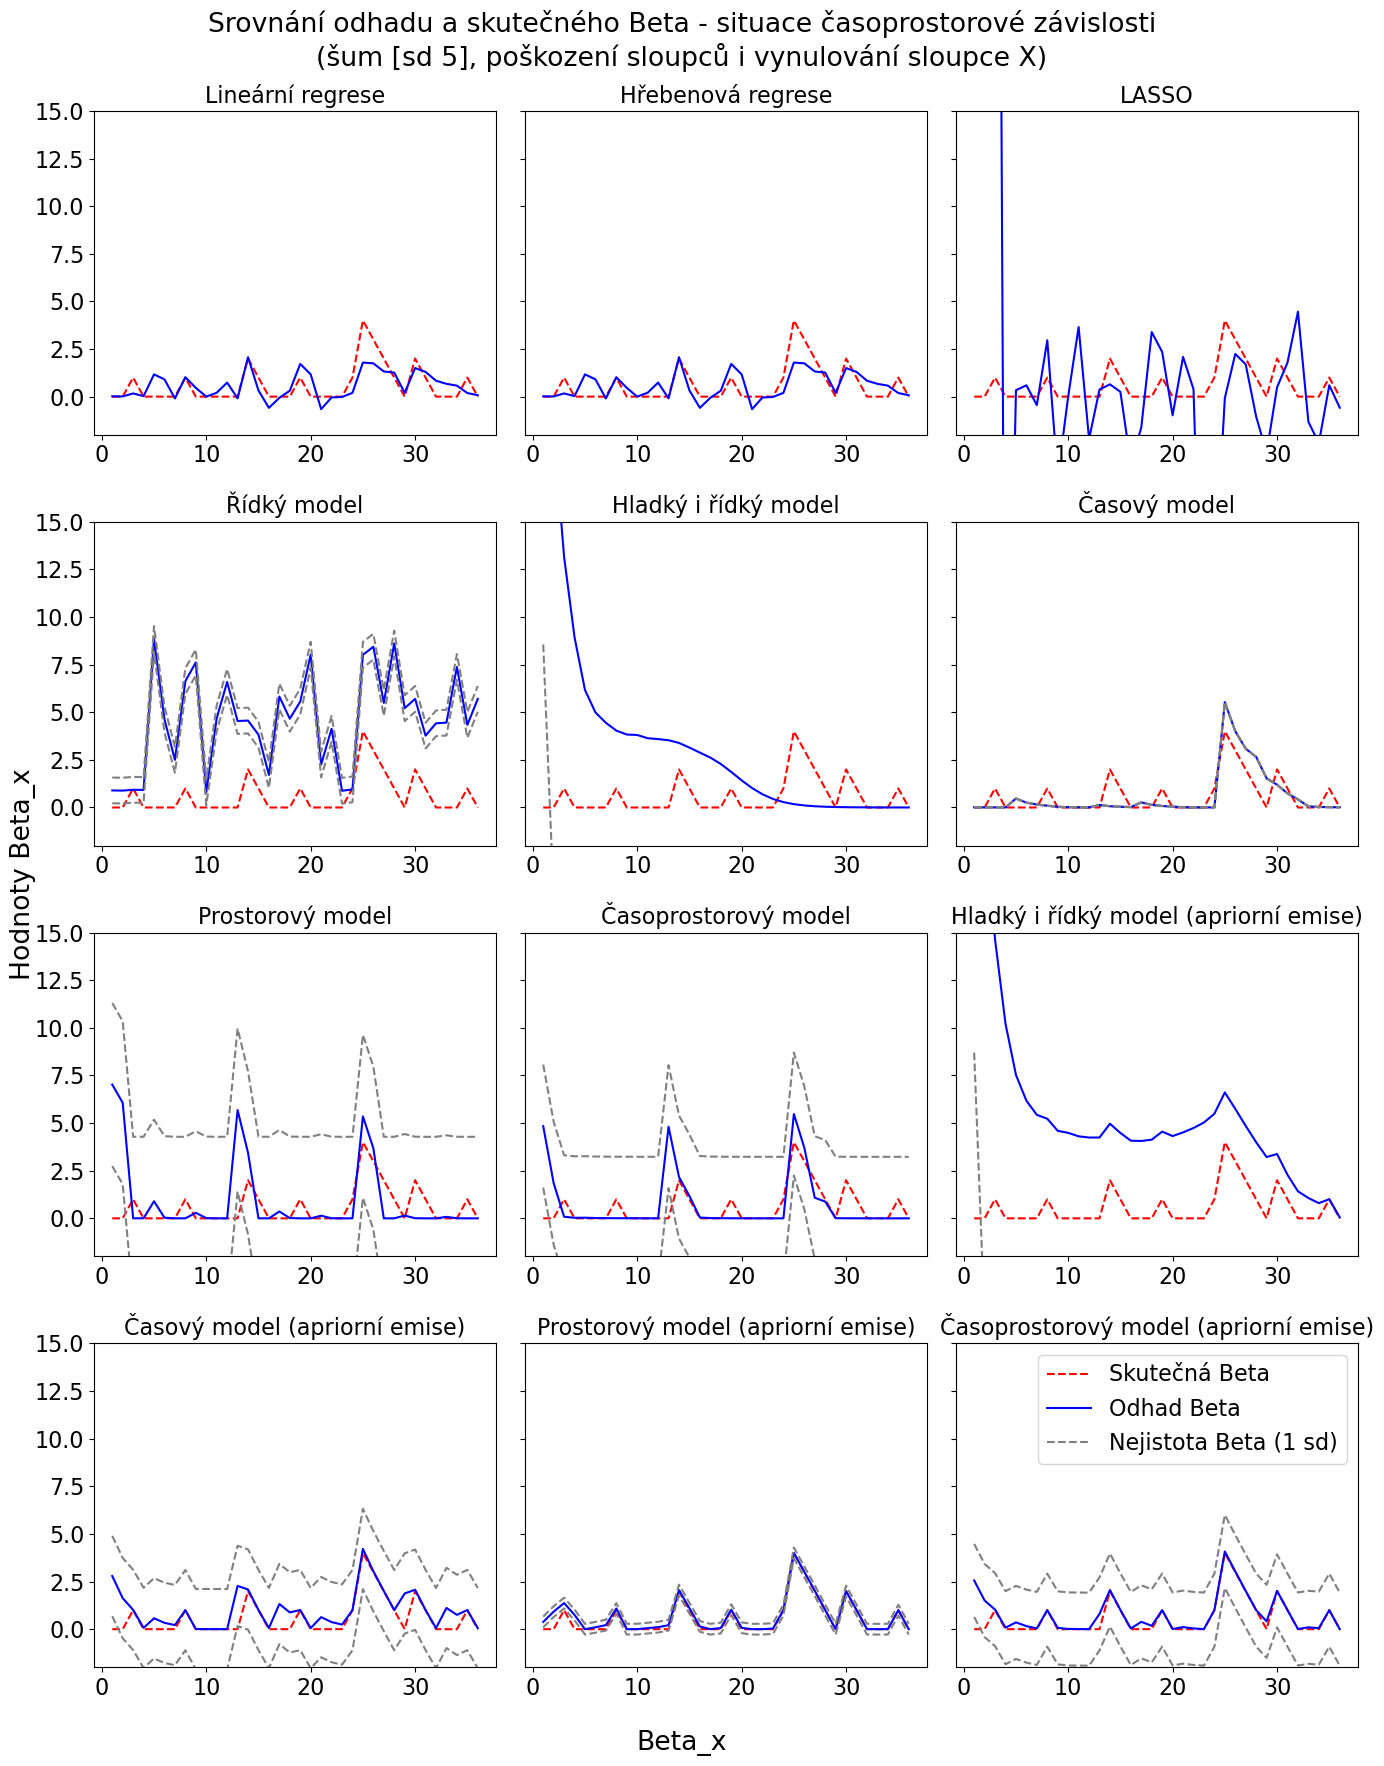

In [31]:
X,y,beta_true = generateData(14, sMatrix, sigma=noiseSigma, damageData=damaged, dropColumn=dropColumn)
plotExperiment(X, y, beta_true, plotTitle=plotTitle, fileTitle=fileTitle)

### Test 2 - obecný test s vyšším šumem

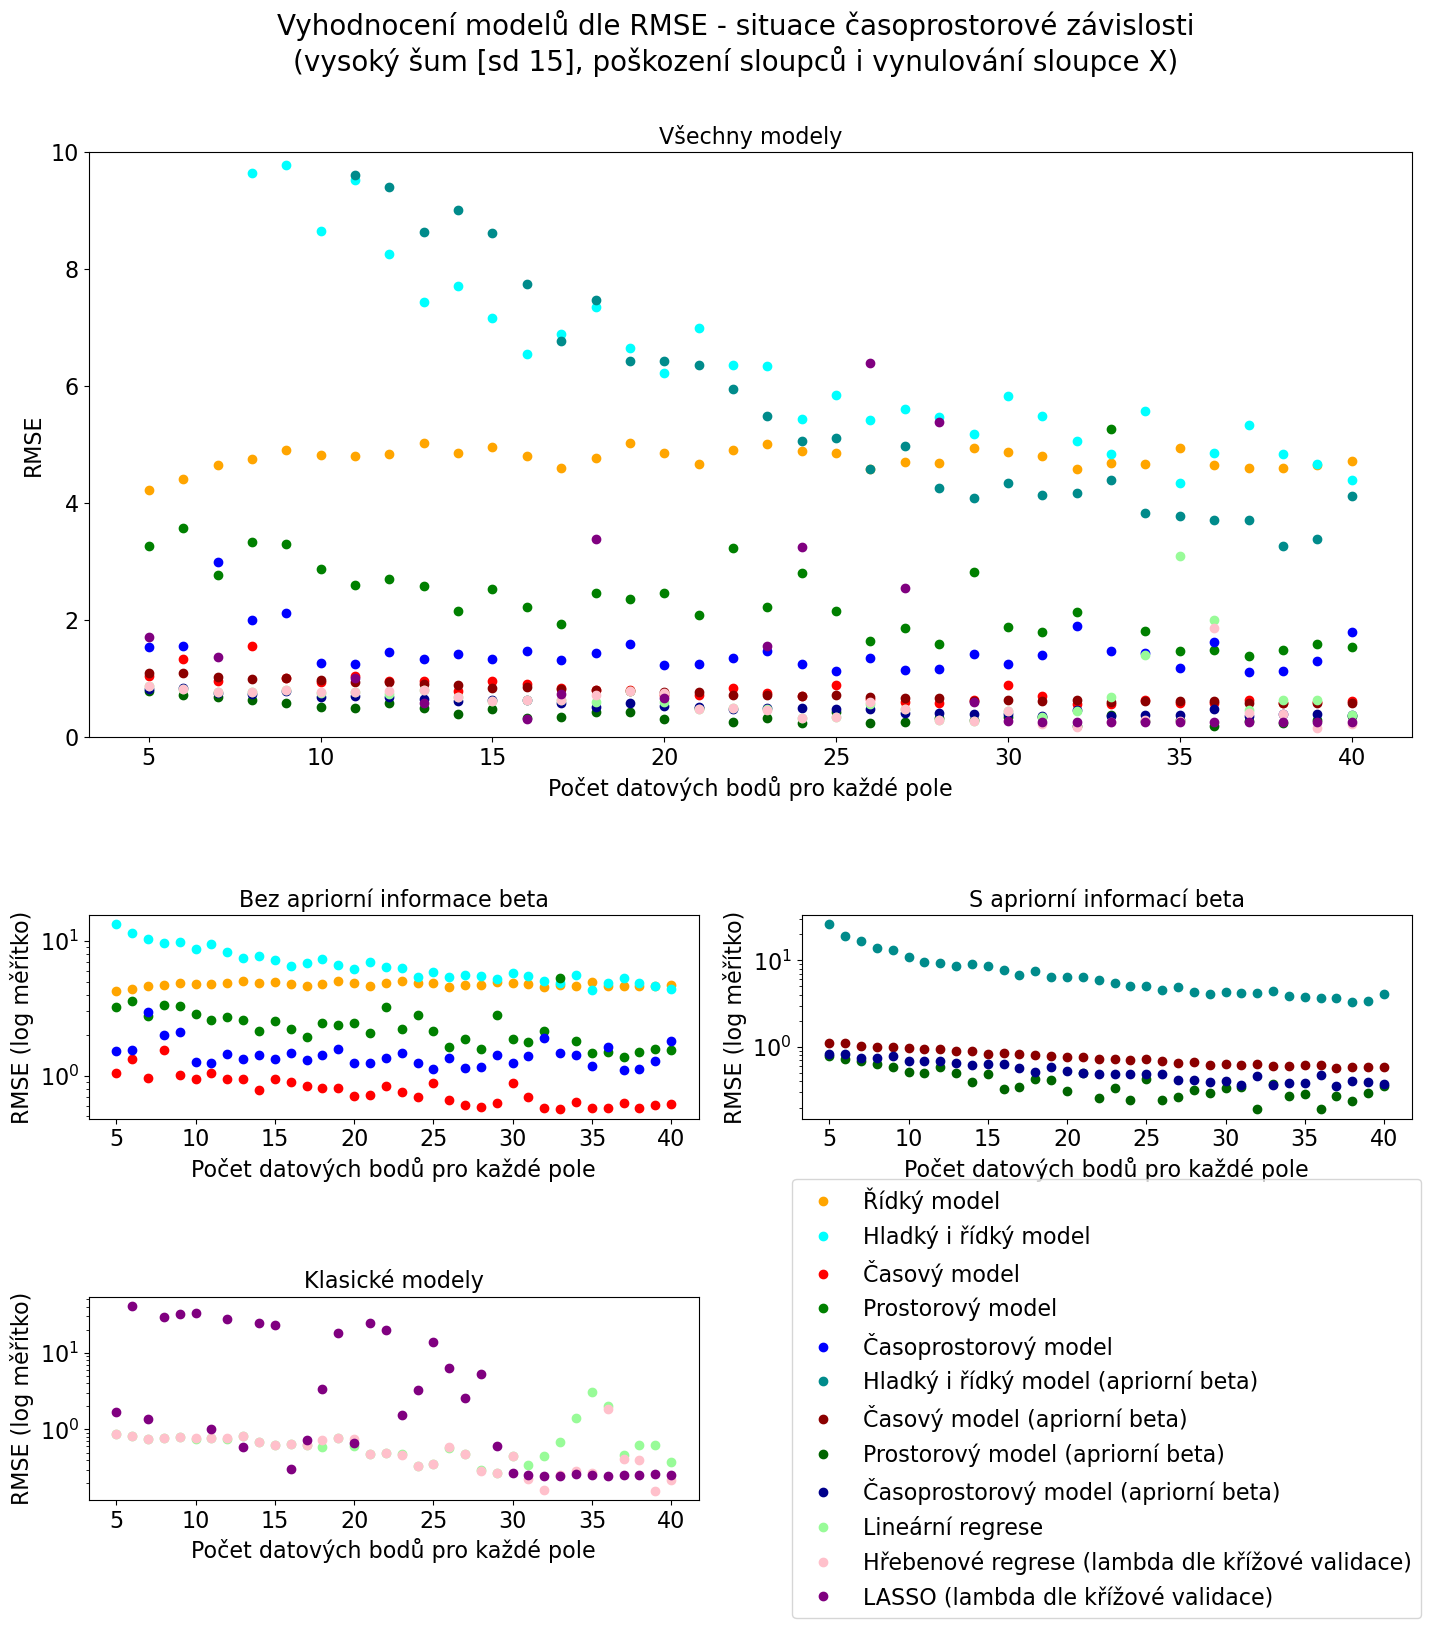

In [32]:
noiseSigma = 15
damaged = True
dropColumn = True
plotTitle = "situace časoprostorové závislosti\n(vysoký šum [sd 15], poškození sloupců i vynulování sloupce X)"
fileTitle = "Situation4GeneralHighNoise"
RunAllSimulations(noiseSigma, damaged, dropColumn, maxData=maxData, seed=40693057, repeat=0, plotTitle=plotTitle, fileTitle=fileTitle)

Lineární regrese - RMSE: 0.692
Hřebenová regrese - RMSE: 0.692
LASSO - RMSE: 24.295
Řídký model - RMSE: 4.862
Hladký i řídký model - RMSE: 7.707
Časový model - RMSE: 0.785
Prostorový model - RMSE: 2.153
Časoprostorový model - RMSE: 1.427
Hladký i řídký model (apriorní emise) - RMSE: 9.015
Časový model (apriorní emise) - RMSE: 0.892
Prostorový model (apriorní emise) - RMSE: 0.393
Časoprostorový model (apriorní emise) - RMSE: 0.611


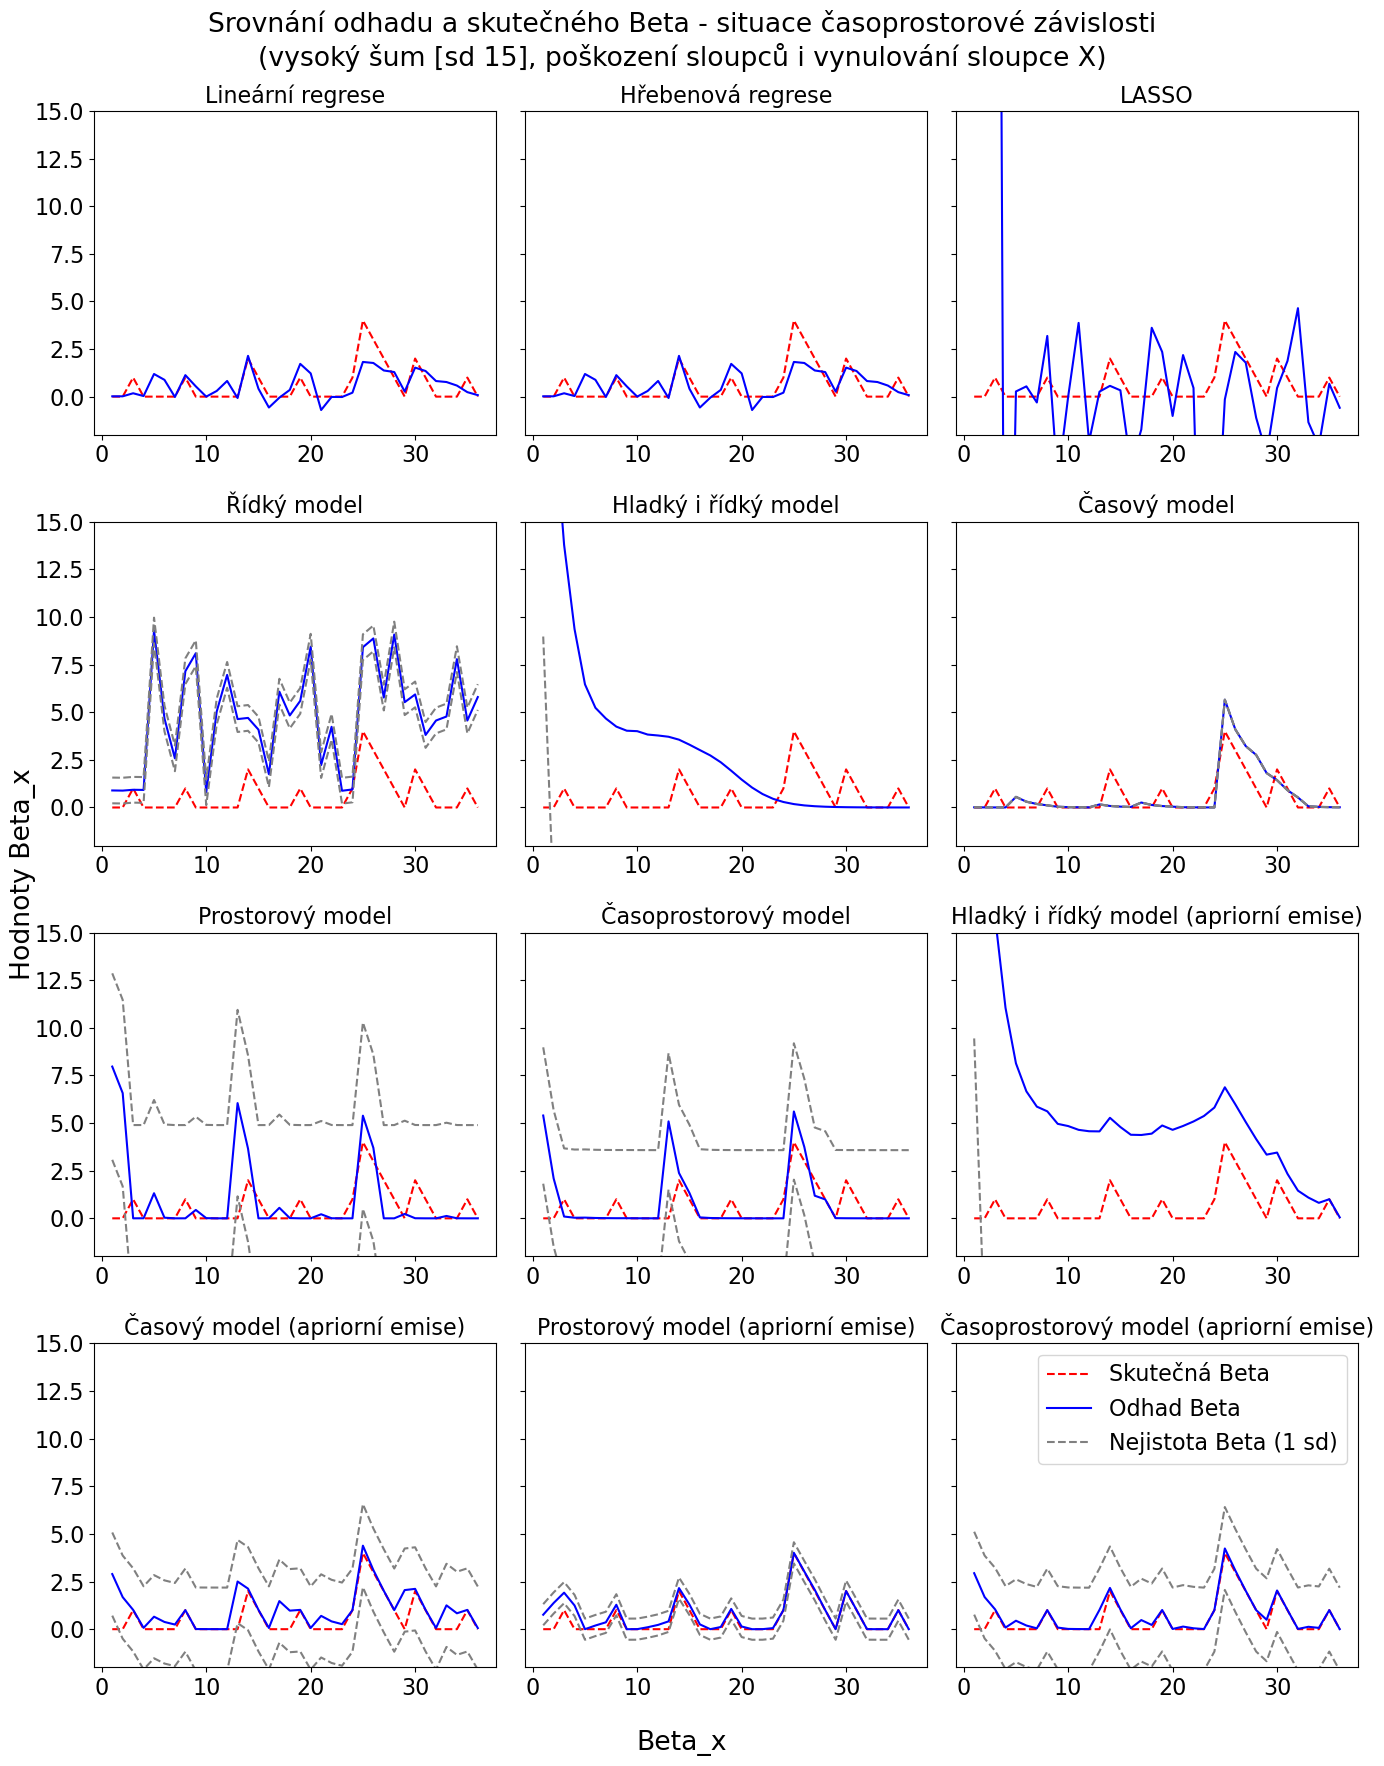

In [33]:
X,y,beta_true = generateData(14, sMatrix, sigma=noiseSigma, damageData=damaged, dropColumn=dropColumn)
plotExperiment(X, y, beta_true, plotTitle=plotTitle, fileTitle=fileTitle)

## Situace 5 - méně řídká explicitní časoprostorová závislost

Situace 5 se odvíjí od situace 4, ale `sMatrix` není řídká (0 jsou nahrazeny 0.5).

In [34]:
sMatrix = np.matrix(
    [
        [0.5,0.5,1,0.5],
        [0.5,0.5,0.5,1],
        [0.5,0.5,0.5,0.5],
        
        [0.5,2,1,0.5],
        [0.5,0.5,1,0.5],
        [0.5,0.5,0.5,1],
        
        [4,3,2,1],
        [0.5,2,1,0.5],
        [0.5,0.5,1,0.5]
    ])

### Test 1 - obecný test

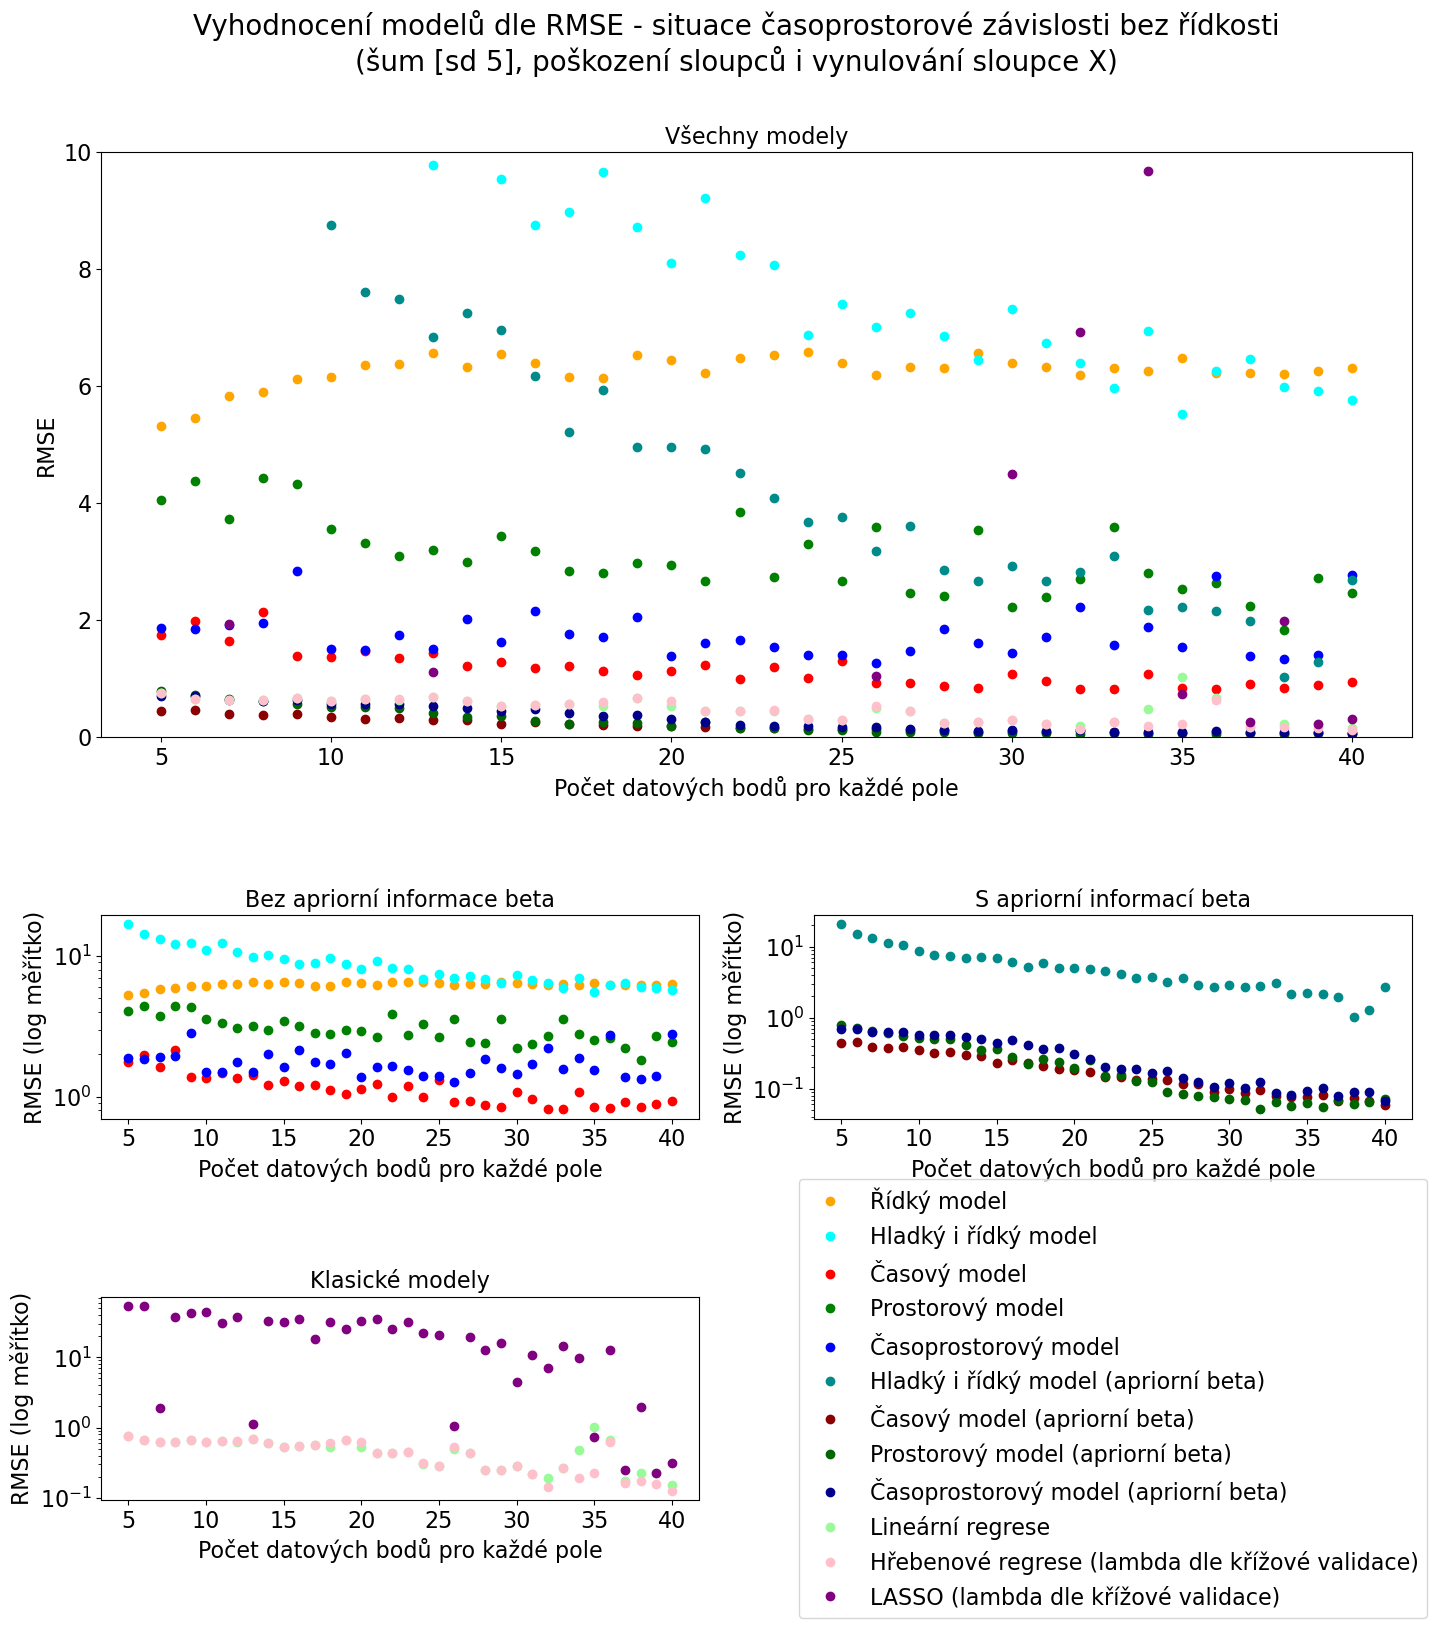

In [35]:
noiseSigma = 5
damaged = True
dropColumn = True
plotTitle = "situace časoprostorové závislosti bez řídkosti\n(šum [sd 5], poškození sloupců i vynulování sloupce X)"
fileTitle = "Situation5General"
RunAllSimulations(noiseSigma, damaged, dropColumn, maxData=maxData, seed=40693057, repeat=0, plotTitle=plotTitle, fileTitle=fileTitle)

Lineární regrese - RMSE: 0.609
Hřebenová regrese - RMSE: 0.609
LASSO - RMSE: 32.573
Řídký model - RMSE: 6.329
Hladký i řídký model - RMSE: 10.119
Časový model - RMSE: 1.212
Prostorový model - RMSE: 2.995
Časoprostorový model - RMSE: 2.023
Hladký i řídký model (apriorní emise) - RMSE: 7.258
Časový model (apriorní emise) - RMSE: 0.292
Prostorový model (apriorní emise) - RMSE: 0.350
Časoprostorový model (apriorní emise) - RMSE: 0.502


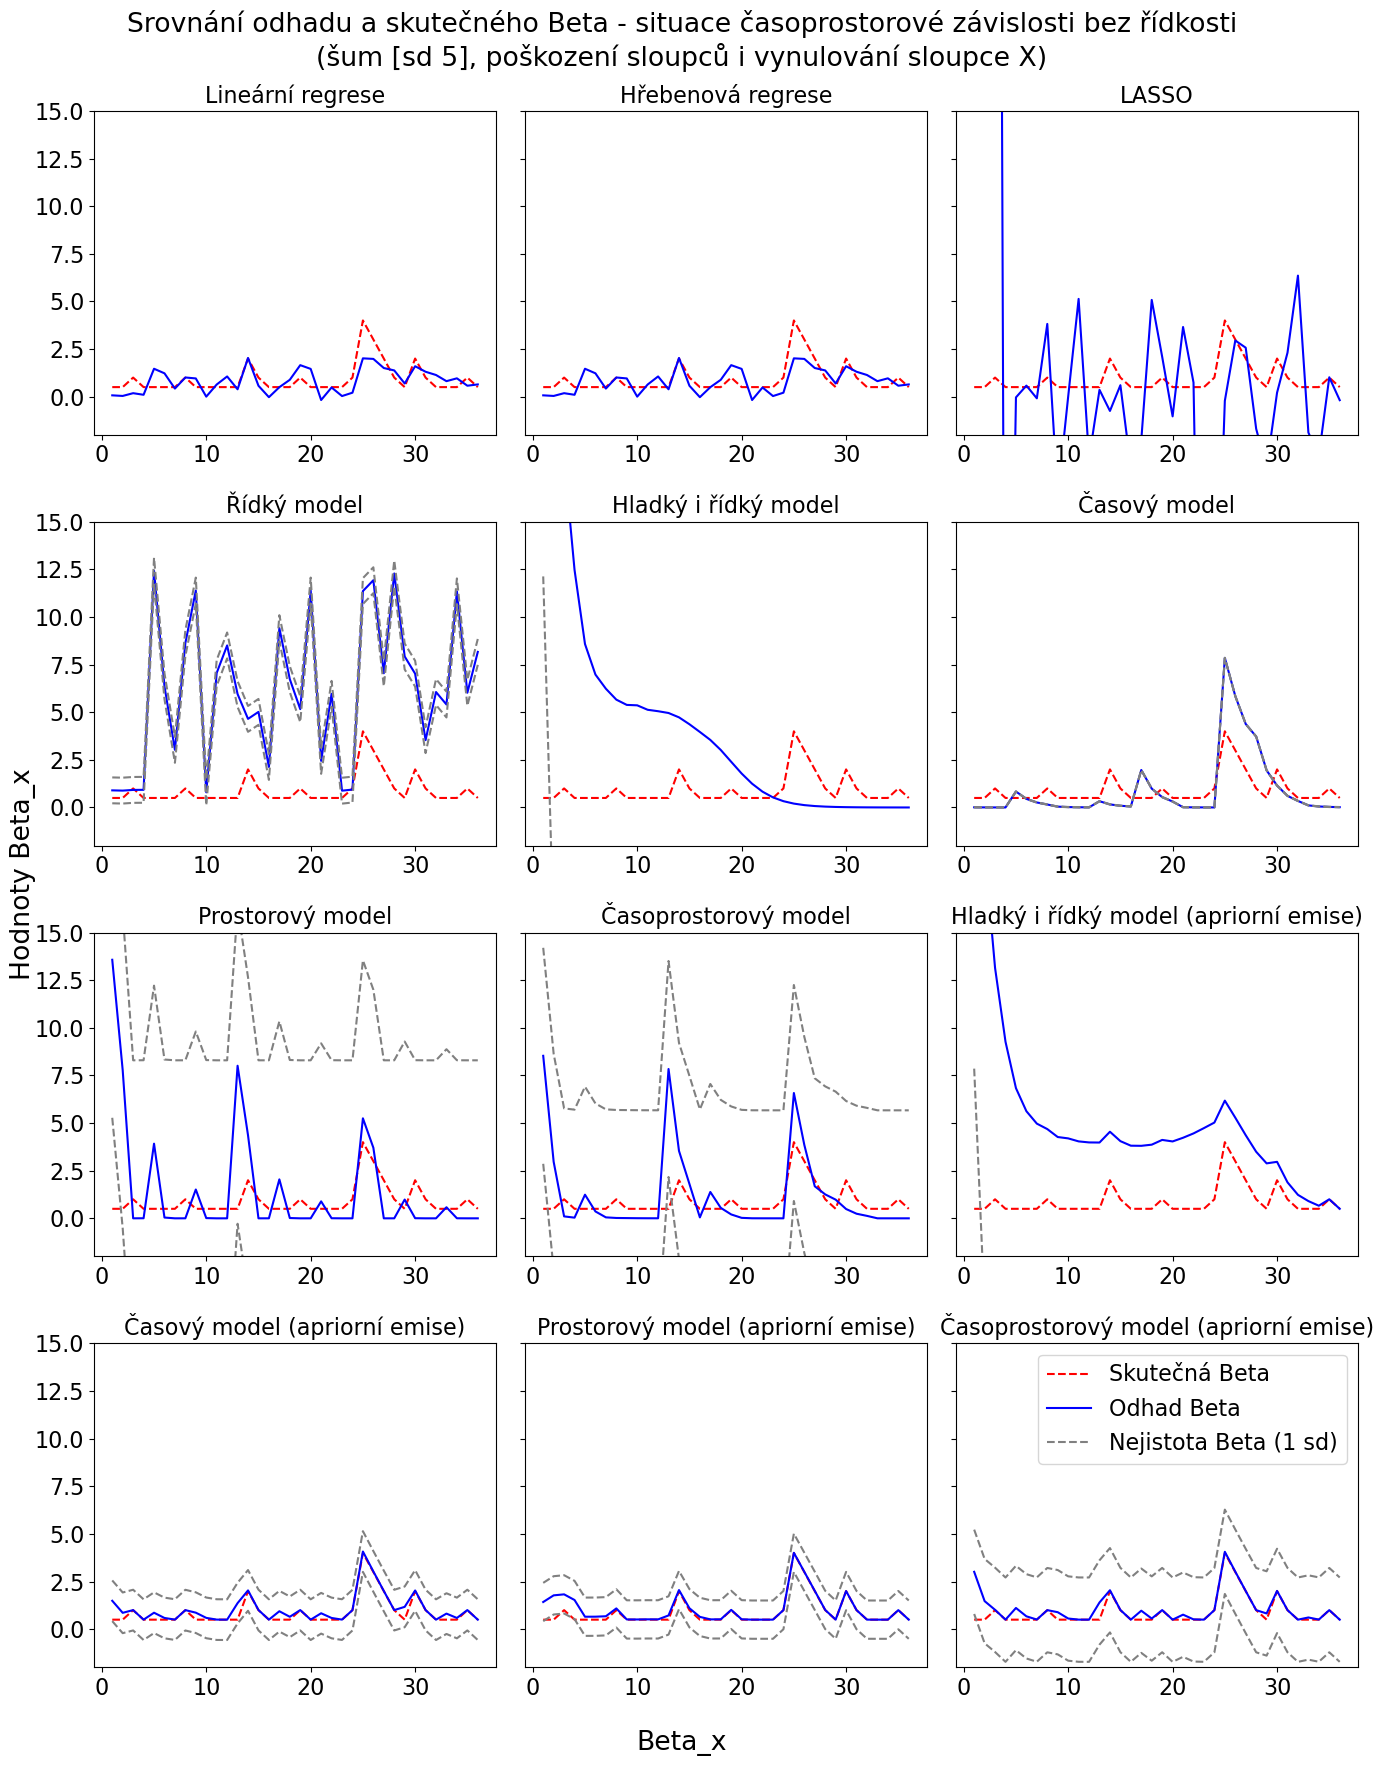

In [36]:
X,y,beta_true = generateData(14, sMatrix, sigma=noiseSigma, damageData=damaged, dropColumn=dropColumn)
plotExperiment(X, y, beta_true, plotTitle=plotTitle, fileTitle=fileTitle)

### Test 2 - obecný test s vyšším šumem

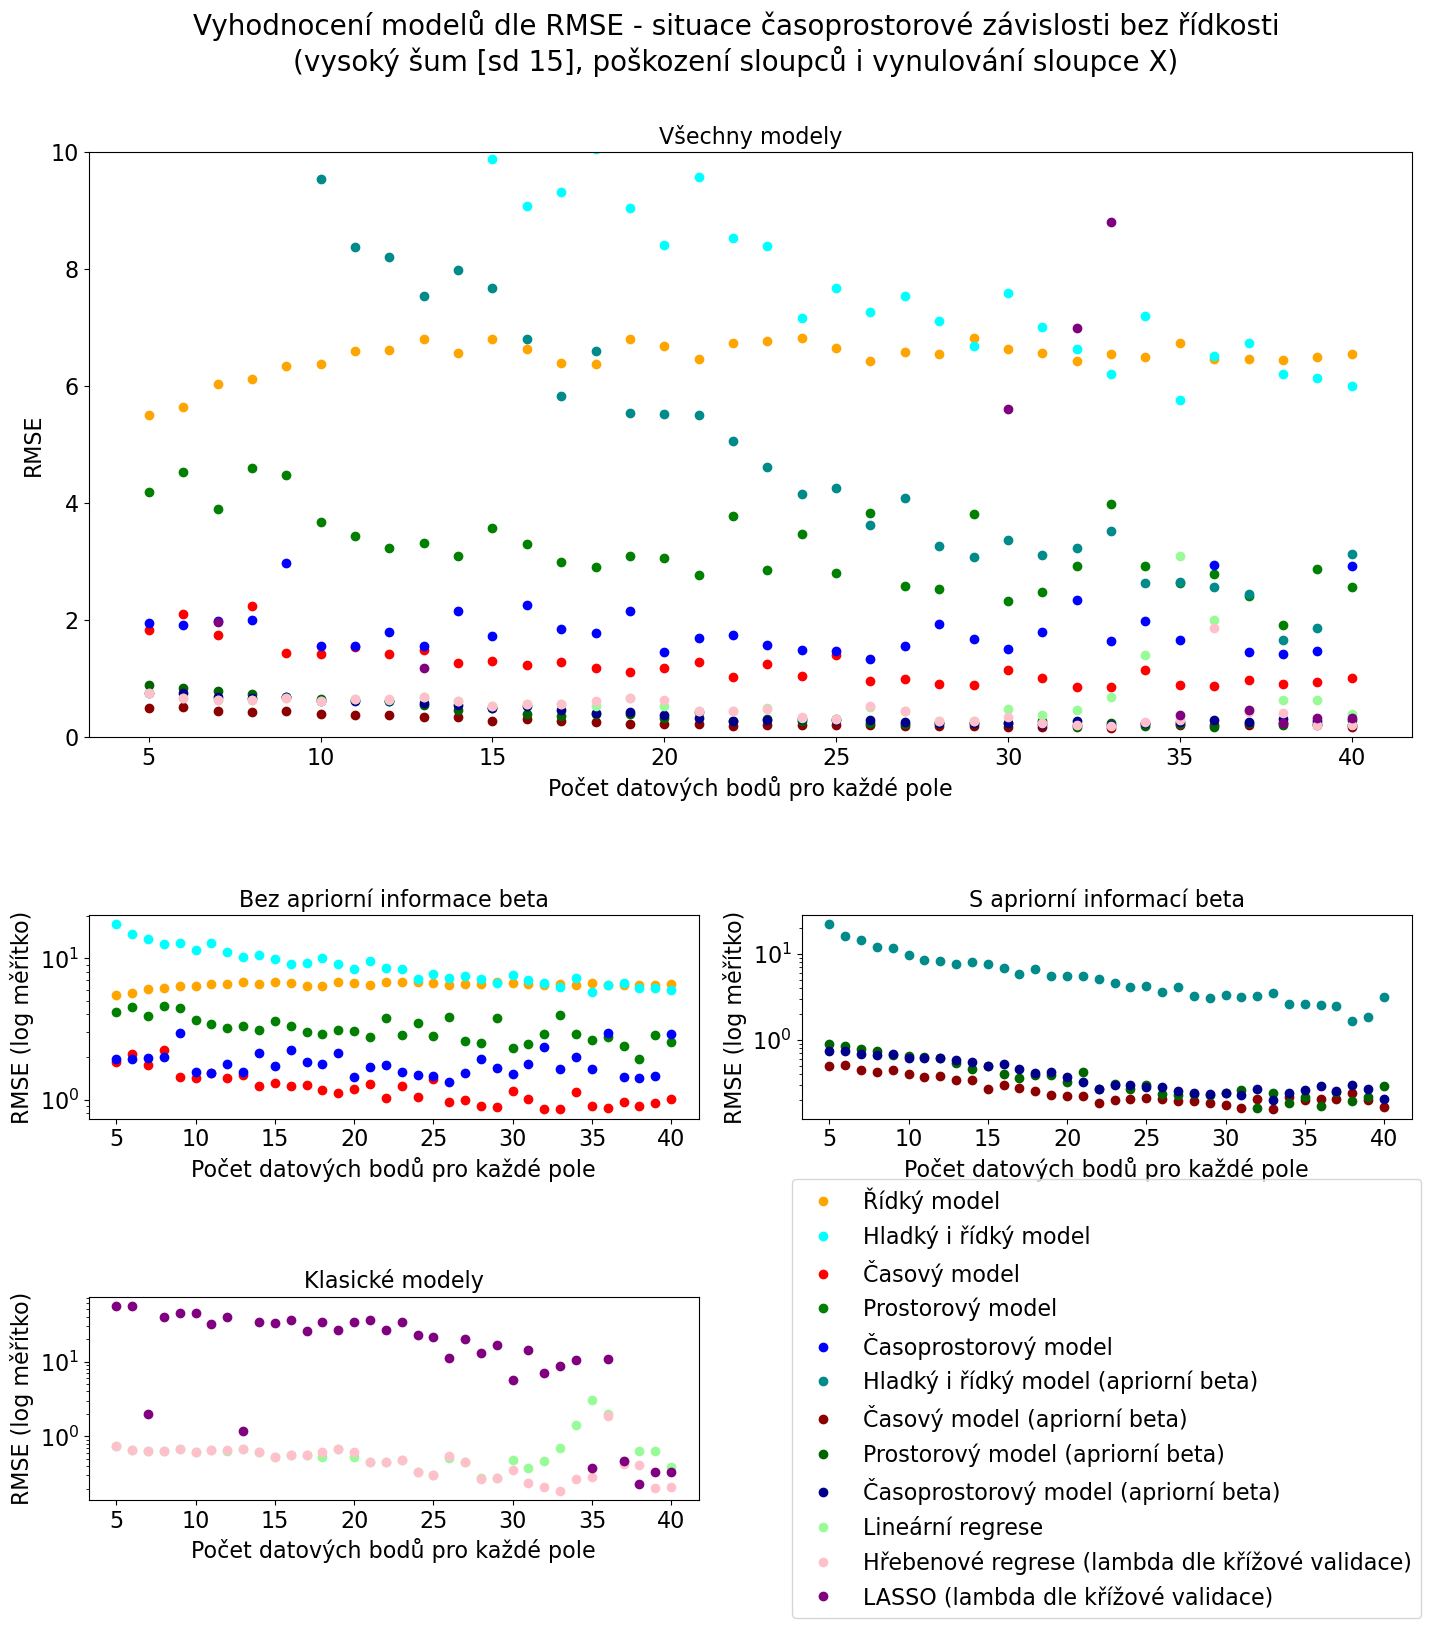

In [37]:
noiseSigma = 15
damaged = True
dropColumn = True
plotTitle = "situace časoprostorové závislosti bez řídkosti\n(vysoký šum [sd 15], poškození sloupců i vynulování sloupce X)"
fileTitle = "Situation5GeneralHighNoise"
RunAllSimulations(noiseSigma, damaged, dropColumn, maxData=maxData, seed=40693057, repeat=0, plotTitle=plotTitle, fileTitle=fileTitle)

Lineární regrese - RMSE: 0.613
Hřebenová regrese - RMSE: 0.613
LASSO - RMSE: 33.858
Řídký model - RMSE: 6.573
Hladký i řídký model - RMSE: 10.461
Časový model - RMSE: 1.258
Prostorový model - RMSE: 3.097
Časoprostorový model - RMSE: 2.148
Hladký i řídký model (apriorní emise) - RMSE: 7.979
Časový model (apriorní emise) - RMSE: 0.341
Prostorový model (apriorní emise) - RMSE: 0.468
Časoprostorový model (apriorní emise) - RMSE: 0.551


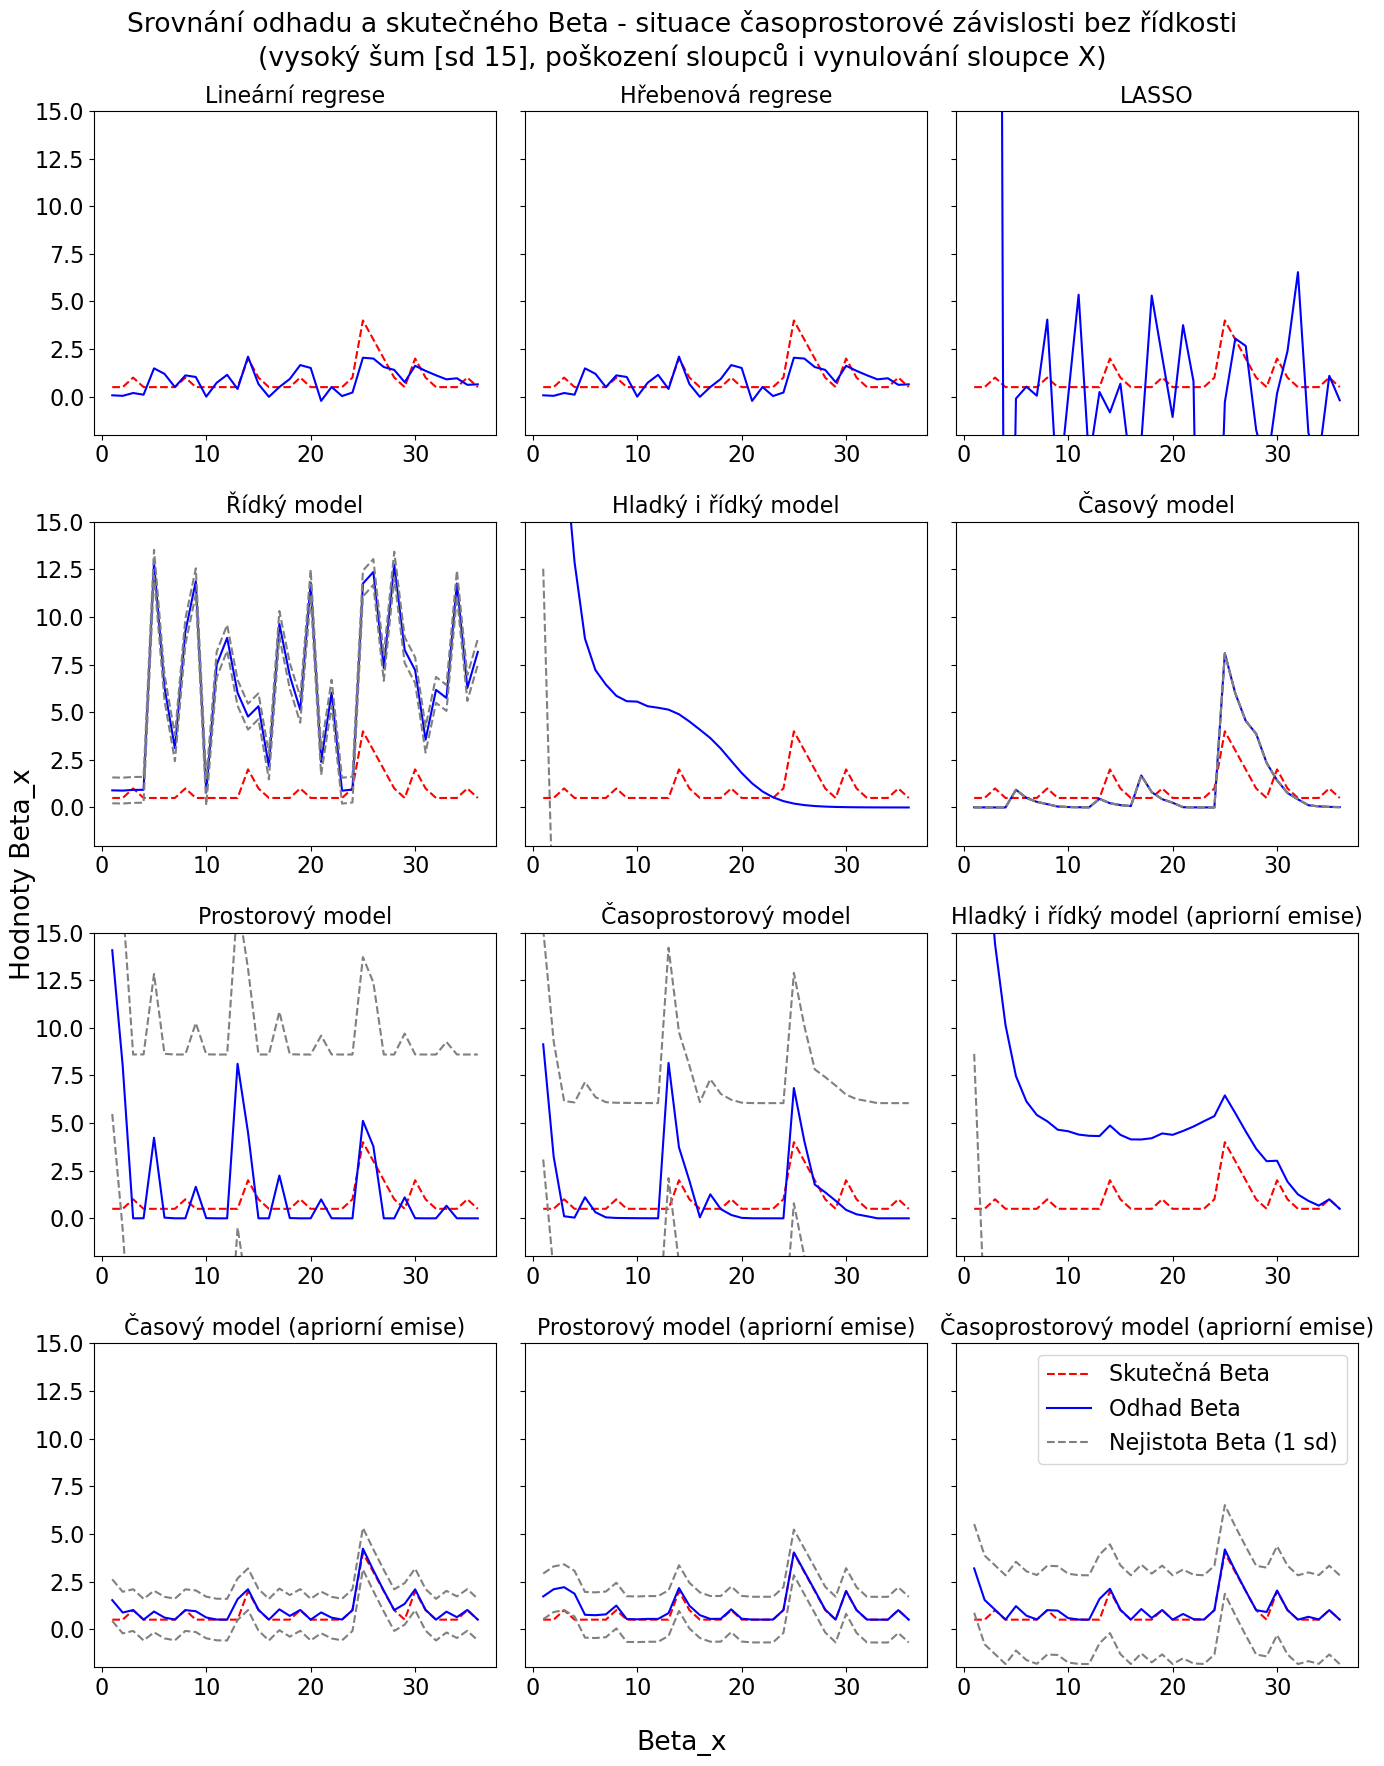

In [38]:
X,y,beta_true = generateData(14, sMatrix, sigma=noiseSigma, damageData=damaged, dropColumn=dropColumn)
plotExperiment(X, y, beta_true, plotTitle=plotTitle, fileTitle=fileTitle)

# Data pro testování modelů 

Toto reprezentuje způsob vytvoření benchmarků ukázaných napříč modely 01-05.

Popis dat: indikátory na 5 políčkách se 3 časy. Umístnění indikátoru 1 bylo zvoleno náhodné, ale byla zvolena jedna 1 u sloupce s poškozením (konkrétně na indexu 2).

In [12]:
sMatrix = np.matrix(
    [
        [0,0,1],
        [0,0,0],
        [0,0,0],
        [1,1,0],
        [0,0,0]
    ])

noiseSigma=1
damaged=[0,1,2]
dropColumn=False

X,y,beta_true = generateData(30,sMatrix,sigma=noiseSigma,damageData=damaged, dropColumn=dropColumn, spaces=sMatrix.shape[0], times=sMatrix.shape[1])
dataDic = {"X":X,"y":y,"beta_true":beta_true}
sio.savemat(f"../dataCustom.mat", dataDic)